# Previsione della Qualità dell'Aria in India

**Progetto di Data Intensive**  
**Autore:** Martin Tomassi, Jacopo Vasi  
**Email:** martin.tomassi@studio.unibo.it , jacopo.vasi@studio.unibo.it  
**Corso:** Data Intensive, Università di Bologna  
**Data:** Aprile 2025

## Caricamento dei Datasets ed Import Librerie



In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

try:
    import google.colab
    running_in_colab = True
except ImportError:
    running_in_colab = False



from sklearn.ensemble import IsolationForest

from IPython.display import clear_output

N_JOBS = -1
RANDOM_STATE = 42

if running_in_colab:
    print("Running on Google Colab")
    !apt-get update -qq
    !apt-get install -qq git-lfs
    !git lfs install
    !git clone https://github.com/vMxster/Data_Project.git
    !cd Data_Project && git lfs pull
    zip_india_path   = "Data_Project/Datasets/dataset_india.zip"
    zip_china_path   = "Data_Project/Datasets/dataset_china.zip"
else:
    print("Running locally in Jupyter")
    zip_india_path   = "Datasets/dataset_india.zip"
    zip_china_path   = "Datasets/dataset_china.zip"



# India Dataset

india_extract_to = "datasets/india"
os.makedirs(india_extract_to, exist_ok=True)

with zipfile.ZipFile(zip_india_path, 'r') as z:
    z.extractall(india_extract_to)

print("\nEstratti:\n")
for root, _, files in os.walk(india_extract_to):
    for f in files:
        print(os.path.join(root, f))

# Cina Dataset

china_extract_to = "datasets/china"
os.makedirs(china_extract_to, exist_ok=True)

with zipfile.ZipFile(zip_china_path, 'r') as z:
    z.extractall(china_extract_to)

print("\nEstratti:\n")
for root, _, files in os.walk(china_extract_to):
    for f in files:
        print(os.path.join(root, f))

Note: you may need to restart the kernel to use updated packages.
Running locally in Jupyter

Estratti:

datasets/india\AP001.csv
datasets/india\AP002.csv
datasets/india\AP003.csv
datasets/india\AP004.csv
datasets/india\AP005.csv
datasets/india\AP006.csv
datasets/india\AP007.csv
datasets/india\AP008.csv
datasets/india\AP009.csv
datasets/india\AP010.csv
datasets/india\AR001.csv
datasets/india\AS001.csv
datasets/india\AS002.csv
datasets/india\AS003.csv
datasets/india\AS004.csv
datasets/india\AS005.csv
datasets/india\AS006.csv
datasets/india\AS007.csv
datasets/india\AS008.csv
datasets/india\AS009.csv
datasets/india\BR001.csv
datasets/india\BR002.csv
datasets/india\BR003.csv
datasets/india\BR004.csv
datasets/india\BR005.csv
datasets/india\BR006.csv
datasets/india\BR007.csv
datasets/india\BR008.csv
datasets/india\BR009.csv
datasets/india\BR010.csv
datasets/india\BR011.csv
datasets/india\BR012.csv
datasets/india\BR013.csv
datasets/india\BR014.csv
datasets/india\BR015.csv
datasets/india\BR016

# Dataset sulla **Qualità dell'Aria in India**



Il dataset in questione è stato messo a disposizione dal Central Pollution Control Board (CPCB), l’ente ufficiale del Governo indiano deputato al monitoraggio e alla gestione dell’inquinamento atmosferico, al fine di raccogliere informazioni relative alle condizioni della qualità dell’aria in 453 città indiane nel periodo compreso tra il 2010 e il 2023.

Sempre citando la documentazione ufficiale, il dataset permette di indagare su numerose variabili ambientali e parametri atmosferici che includono:

- PM10 e PM2.5: concentrazioni di particolato in ug/m³;
- CO e CO₂: rispettivamente monossido e anidride carbonica, misurati in vari formati (mg/m³, ppm, ecc.);
- NO, NO₂ e NOx: varianti degli ossidi di azoto, riportati in unità adatte (ug/m³, ppb, ppm);
- SO₂, NH₃ e altri inquinanti quali Benzene, CH₄, e composti organici come MP-Xylene, Eth-Benzene, O Xylene, e Xylene;
- Parametri meteorologici e ambientali quali temperatura, pressione barometrica, umidità relativa, velocità e direzione del vento, radiazione solare e precipitazioni.

In aggiunta al dataset principale, è disponibile anche il file “stations_info.csv”, che rappresenta una guida di riferimento per approfondire le informazioni relative alle diverse stazioni di monitoraggio. Questo file include le seguenti intestazioni:

- file_name: nome del file associato alla stazione;
- state: lo stato in cui è ubicata la stazione;
- city: la città in cui la stazione opera;
- agency: l’ente responsabile della gestione della stazione;
- station_location: dettagli aggiuntivi riguardanti la posizione;
- start_month, start_month_num e start_year: informazioni sulla data di inizio della raccolta dati per ciascuna stazione.

Si procede alla lettura del file contenente le informazioni relative alle varie stazioni di monitoraggio. Successivamente, verranno rimosse alcune colonne ritenute non necessarie per l'analisi in corso, al fine di semplificare la struttura del dataset ed enfatizzare solo le informazioni rilevanti.

In [2]:
df_states = pd.read_csv(f'{india_extract_to}/stations_info.csv')
df_states.drop(columns=['agency', 'station_location', 'start_month'], inplace=True)
df_states.head()

file_name           state               city  start_month_num  start_year
0     AP001  Andhra Pradesh           Tirupati                7        2016
1     AP002  Andhra Pradesh         Vijayawada                5        2017
2     AP003  Andhra Pradesh      Visakhapatnam                7        2017
3     AP004  Andhra Pradesh  Rajamahendravaram                9        2017
4     AP005  Andhra Pradesh          Amaravati               11        2017

Si crea una lista di tutti gli stati presenti nel dataset, assicurandosi di includere ciascun nome una sola volta. Questo passaggio fornisce una visione d’insieme delle regioni coperte dai dati, supportando analisi geografiche e suddivisioni successive.

In [3]:
unique_states = df_states['state'].unique()
unique_states

array(['Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar',
       'Chhattisgarh', 'Chandigarh', 'Delhi', 'Gujarat',
       'Himachal Pradesh', 'Haryana', 'Jharkhand', 'Jammu and Kashmir',
       'Karnataka', 'Kerala', 'Maharashtra', 'Meghalaya', 'Manipur',
       'Madhya Pradesh', 'Mizoram', 'Nagaland', 'Odisha', 'Punjab',
       'Puducherry', 'Rajasthan', 'Sikkim', 'Telangana', 'Tamil Nadu',
       'Tripura', 'Uttarakhand', 'Uttar Pradesh', 'West Bengal'],
      dtype=object)

Questa funzione consente di raccogliere, integrare e unificare dati relativi alla qualità dell’aria provenienti da più file CSV associati a diverse località di un determinato stato. La strategia prevede innanzitutto l’individuazione automatica di tutti i file relativi ad uno specifico stato, grazie all’utilizzo di un codice identificativo presente all’inizio del nome di ciascun file. Una volta selezionati i file pertinenti, il contenuto di ciascuno viene letto e trasformato in una struttura dati standardizzata. Durante questo processo, viene aggiunta ad ogni insieme di dati un’informazione supplementare che indica la città di appartenenza, garantendo così che ogni record contenga il riferimento geografico completo. Alla fine, i singoli dataset vengono combinati in un’unica struttura dati, offrendo un quadro complessivo che facilita un’analisi omogenea e dettagliata delle tendenze e delle variabili relative alla qualità dell’aria all’interno dello stato esaminato.

In [4]:
from pathlib import Path
import pandas as pd
import glob

def combine_state_df(state_name):
    state_code = df_states[df_states['state'] == state_name]['file_name'].iloc[0][:2]
    
    if running_in_colab:
        state_files = glob.glob(f'{india_extract_to}/{state_code}*.csv')
    else:
        state_files = [str(p.as_posix()) for p in Path(india_extract_to).glob(f'{state_code}*.csv')]
    
    combined_df = []
    for state_file in state_files:
        file_name = state_file.split(f'{india_extract_to}/')[1][:-4]  # remove .csv
        file_df = pd.read_csv(state_file)
        
        # Add city and state information
        file_df['city'] = df_states[df_states['file_name'] == file_name]['city'].values[0]
        file_df['city'] = file_df['city'].astype('string')
        file_df['state'] = state_name  # Add the state name
        
        combined_df.append(file_df)

    return pd.concat(combined_df, ignore_index=True)

In [5]:
# Get list of all unique state names
unique_states = df_states['state'].unique()

# Combine all states' data
df_india = pd.concat([combine_state_df(state) for state in unique_states], ignore_index=True)

# Optional: show all columns when displaying the DataFrame
pd.set_option('display.max_columns', None)

# Inspect the combined DataFrame
df_india.info()
df_india.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14295663 entries, 0 to 14295662
Data columns (total 99 columns):
 #   Column               Dtype  
---  ------               -----  
 0   From Date            object 
 1   To Date              object 
 2   PM2.5 (ug/m3)        float64
 3   PM10 (ug/m3)         float64
 4   NO (ug/m3)           float64
 5   NO2 (ug/m3)          float64
 6   NOx (ppb)            float64
 7   NH3 (ug/m3)          float64
 8   SO2 (ug/m3)          float64
 9   CO (mg/m3)           float64
 10  Ozone (ug/m3)        float64
 11  Benzene (ug/m3)      float64
 12  Toluene (ug/m3)      float64
 13  Temp (degree C)      float64
 14  RH (%)               float64
 15  WS (m/s)             float64
 16  WD (deg)             float64
 17  SR (W/mt2)           float64
 18  BP (mmHg)            float64
 19  VWS (m/s)            float64
 20  Xylene (ug/m3)       float64
 21  RF (mm)              float64
 22  AT (degree C)        float64
 23  city                 string 
 

From Date              To Date  PM2.5 (ug/m3)  PM10 (ug/m3)  \
0  2016-07-01 10:00:00  2016-07-01 11:00:00          10.67          39.0   
1  2016-07-01 11:00:00  2016-07-01 12:00:00           2.00          39.0   
2  2016-07-01 12:00:00  2016-07-01 13:00:00            NaN           NaN   
3  2016-07-01 13:00:00  2016-07-01 14:00:00            NaN           NaN   
4  2016-07-01 14:00:00  2016-07-01 15:00:00          20.50          50.0   

   NO (ug/m3)  NO2 (ug/m3)  NOx (ppb)  NH3 (ug/m3)  SO2 (ug/m3)  CO (mg/m3)  \
0       17.67         39.2      32.33         7.07         6.60        0.48   
1       20.50         41.9      35.80         7.40          NaN        0.49   
2         NaN          NaN        NaN          NaN          NaN         NaN   
3         NaN          NaN        NaN          NaN          NaN         NaN   
4       15.40         43.6      32.78         6.35         6.38        0.47   

   Ozone (ug/m3)  Benzene (ug/m3)  Toluene (ug/m3)  Temp (degree C)  RH (%)  \
0           14.5              1.0             4.63            33.43   71.67   
1           15.0              0.7             4.50            33.70   70.00   
2            NaN              NaN              NaN              NaN     NaN   
3            NaN              NaN              NaN              NaN     NaN   
4           10.5              0.6             4.50            33.57   63.50   

   WS (m/s)  WD (deg)  SR (W/mt2)  BP (mmHg)  VWS (m/s)  Xylene (ug/m3)  \
0      2.30    226.33      123.67        NaN       -0.1             0.1   
1      2.50    223.00      186.00        NaN       -0.1             0.1   
2       NaN       NaN         NaN        NaN        NaN             NaN   
3       NaN       NaN         NaN        NaN        NaN             NaN   
4      1.88    223.00      240.50        NaN       -0.1             0.1   

   RF (mm)  AT (degree C)      city           state  Eth-Benzene (ug/m3)  \
0      0.0          23.05  Tirupati  Andhra Pradesh                  NaN   
1      0.0            NaN  Tirupati  Andhra Pradesh                  NaN   
2      NaN            NaN  Tirupati  Andhra Pradesh                  NaN   
3      NaN            NaN  Tirupati  Andhra Pradesh                  NaN   
4      0.0            NaN  Tirupati  Andhra Pradesh                  NaN   

   MP-Xylene (ug/m3)  O Xylene (ug/m3)  VWS (degree)  WD (degree)  Temp ()  \
0                NaN               NaN           NaN          NaN      NaN   
1                NaN               NaN           NaN          NaN      NaN   
2                NaN               NaN           NaN          NaN      NaN   
3                NaN               NaN           NaN          NaN      NaN   
4                NaN               NaN           NaN          NaN      NaN   

   RF ()  NO (mg/m3)  AT ()  CO (mg/Nm3)  RF (m/s)  SR (ug/m3)  MP-Xylene ()  \
0    NaN         NaN    NaN          NaN       NaN         NaN           NaN   
1    NaN         NaN    NaN          NaN       NaN         NaN           NaN   
2    NaN         NaN    NaN          NaN       NaN         NaN           NaN   
3    NaN         NaN    NaN          NaN       NaN         NaN           NaN   
4    NaN         NaN    NaN          NaN       NaN         NaN           NaN   

   CH4 (ug/m3)  NMHC (ug/m3)  THC (ug/m3)  Gust (km/hr)  Variance (n)  \
0          NaN           NaN          NaN           NaN           NaN   
1          NaN           NaN          NaN           NaN           NaN   
2          NaN           NaN          NaN           NaN           NaN   
3          NaN           NaN          NaN           NaN           NaN   
4          NaN           NaN          NaN           NaN           NaN   

   Power (W)  CO2 (mg/m3)  Ozone (ppb)  Gust (kl/h)  Gust (m/s)  WS ()  \
0        NaN          NaN          NaN          NaN         NaN    NaN   
1        NaN          NaN          NaN          NaN         NaN    NaN   
2        NaN          NaN          NaN          NaN         NaN    NaN   
3        NaN 

Dall’analisi del dataframe risulta che per lo stato di Delhi sono presenti 58 metriche diverse distribuite su un totale di 2.796.171 record.

## Pre-elaborazione dei dati

#### Utilizzo di ‘From Date’ come indice temporale

Nel dataset sono presenti due colonne di tipo oggetto, `From Date` e `To Date`, che indicano l’inizio e la fine di ciascuna finestra oraria di misurazione. Per gestire efficacemente le serie storiche, trasformiamo `From Date` in un indice datetime, eliminando poi la colonna `To Date`.

In [6]:
def create_dt_index(dataframe):
    dataframe = dataframe.drop(columns='To Date')
    dataframe['From Date'] = pd.to_datetime(dataframe['From Date'])
    dataframe = dataframe.rename(columns={'From Date': 'datetime'})
    return dataframe.set_index('datetime')

In [7]:
df_india = create_dt_index(df_india)
df_india.head(2)

PM2.5 (ug/m3)  PM10 (ug/m3)  NO (ug/m3)  NO2 (ug/m3)  \
datetime                                                                    
2016-07-01 10:00:00          10.67          39.0       17.67         39.2   
2016-07-01 11:00:00           2.00          39.0       20.50         41.9   

                     NOx (ppb)  NH3 (ug/m3)  SO2 (ug/m3)  CO (mg/m3)  \
datetime                                                               
2016-07-01 10:00:00      32.33         7.07          6.6        0.48   
2016-07-01 11:00:00      35.80         7.40          NaN        0.49   

                     Ozone (ug/m3)  Benzene (ug/m3)  Toluene (ug/m3)  \
datetime                                                               
2016-07-01 10:00:00           14.5              1.0             4.63   
2016-07-01 11:00:00           15.0              0.7             4.50   

                     Temp (degree C)  RH (%)  WS (m/s)  WD (deg)  SR (W/mt2)  \
datetime                                                                       
2016-07-01 10:00:00            33.43   71.67       2.3    226.33      123.67   
2016-07-01 11:00:00            33.70   70.00       2.5    223.00      186.00   

                     BP (mmHg)  VWS (m/s)  Xylene (ug/m3)  RF (mm)  \
datetime                                                             
2016-07-01 10:00:00        NaN       -0.1             0.1      0.0   
2016-07-01 11:00:00        NaN       -0.1             0.1      0.0   

                     AT (degree C)      city           state  \
datetime                                                       
2016-07-01 10:00:00          23.05  Tirupati  Andhra Pradesh   
2016-07-01 11:00:00            NaN  Tirupati  Andhra Pradesh   

                     Eth-Benzene (ug/m3)  MP-Xylene (ug/m3)  O Xylene (ug/m3)  \
datetime                                                                        
2016-07-01 10:00:00                  NaN                NaN               NaN   
2016-07-01 11:00:00                  NaN                NaN               NaN   

                     VWS (degree)  WD (degree)  Temp ()  RF ()  NO (mg/m3)  \
datetime                                                                     
2016-07-01 10:00:00           NaN          NaN      NaN    NaN         NaN   
2016-07-01 11:00:00           NaN          NaN      NaN    NaN         NaN   

                     AT ()  CO (mg/Nm3)  RF (m/s)  SR (ug/m3)  MP-Xylene ()  \
datetime                                                                      
2016-07-01 10:00:00    NaN          NaN       NaN         NaN           NaN   
2016-07-01 11:00:00    NaN          NaN       NaN         NaN           NaN   

                     CH4 (ug/m3)  NMHC (ug/m3)  THC (ug/m3)  Gust (km/hr)  \
datetime                                                                    
2016-07-01 10:00:00          NaN           NaN          NaN           NaN   
2016-07-01 11:00:00          NaN           NaN          NaN           NaN   

                     Variance (n)  Power (W)  CO2 (mg/m3)  Ozone (ppb)  \
datetime                                                                 
2016-07-01 10:00:00           NaN        NaN          NaN          NaN   
2016-07-01 11:00:00           NaN        NaN          NaN          NaN   

                     Gust (kl/h)  Gust (m/s)  WS ()  SPM (ug/m3)  MH (m)  \
datetime                                                                   
2016-07-01 10:00:00          NaN         NaN    NaN          NaN     NaN   
2016-07-01 11:00:00          NaN         NaN    NaN          NaN     NaN   

                     HCHO (ug/m3)  Hg (ug/m3)  CO (ug/m3)  Toluene ()  \
datetime                                                                
2016-07-01 10:00:00           NaN         NaN         NaN         NaN   
2016-07-01 11:00:00           NaN         NaN         NaN         NaN   

                     CO (ng/m3)  NOx (ug/m3)  WD (degree C)  Benzene ()  \
datetime                                 

### Feature Reduction

Dall’esame del dataframe emerge che alcune colonne contengono informazioni sovrapposte. Per individuare possibili duplicazioni e fusioni, confronteremo gli andamenti delle medie annuali delle variabili raggruppate. Per ciascun gruppo, aggregheremo i valori per anno e tracceremo un grafico a linee in una griglia, in modo da mettere in evidenza trend comuni e facilitare l’individuazione di correlazioni tra le feature.

In [8]:
def plot_feature_similarities(dataframe, feature_groups, columns=2):
    rows = int((len(feature_groups)/columns)//1)
    fig, axes = plt.subplots(rows, columns, figsize=(13, 4*rows))
    fig.tight_layout(pad=3.0)

    row_num = 0
    col_num = 0
    for pos, group in enumerate(feature_groups):
        if pos % columns == 0 and pos != 0:
            row_num += 1
            col_num = 0

        for feature in feature_groups[group]:
            df_feature = dataframe[dataframe[feature].notnull()][feature]
            df_feature = df_feature.groupby([df_feature.index.year]).mean(numeric_only=True)
            sns.lineplot(data=df_feature, label=feature, ax=axes[row_num, col_num])
        axes[row_num, col_num].set_title(group)
        axes[row_num, col_num].set(xlabel=None)
        col_num += 1

    plt.plot()

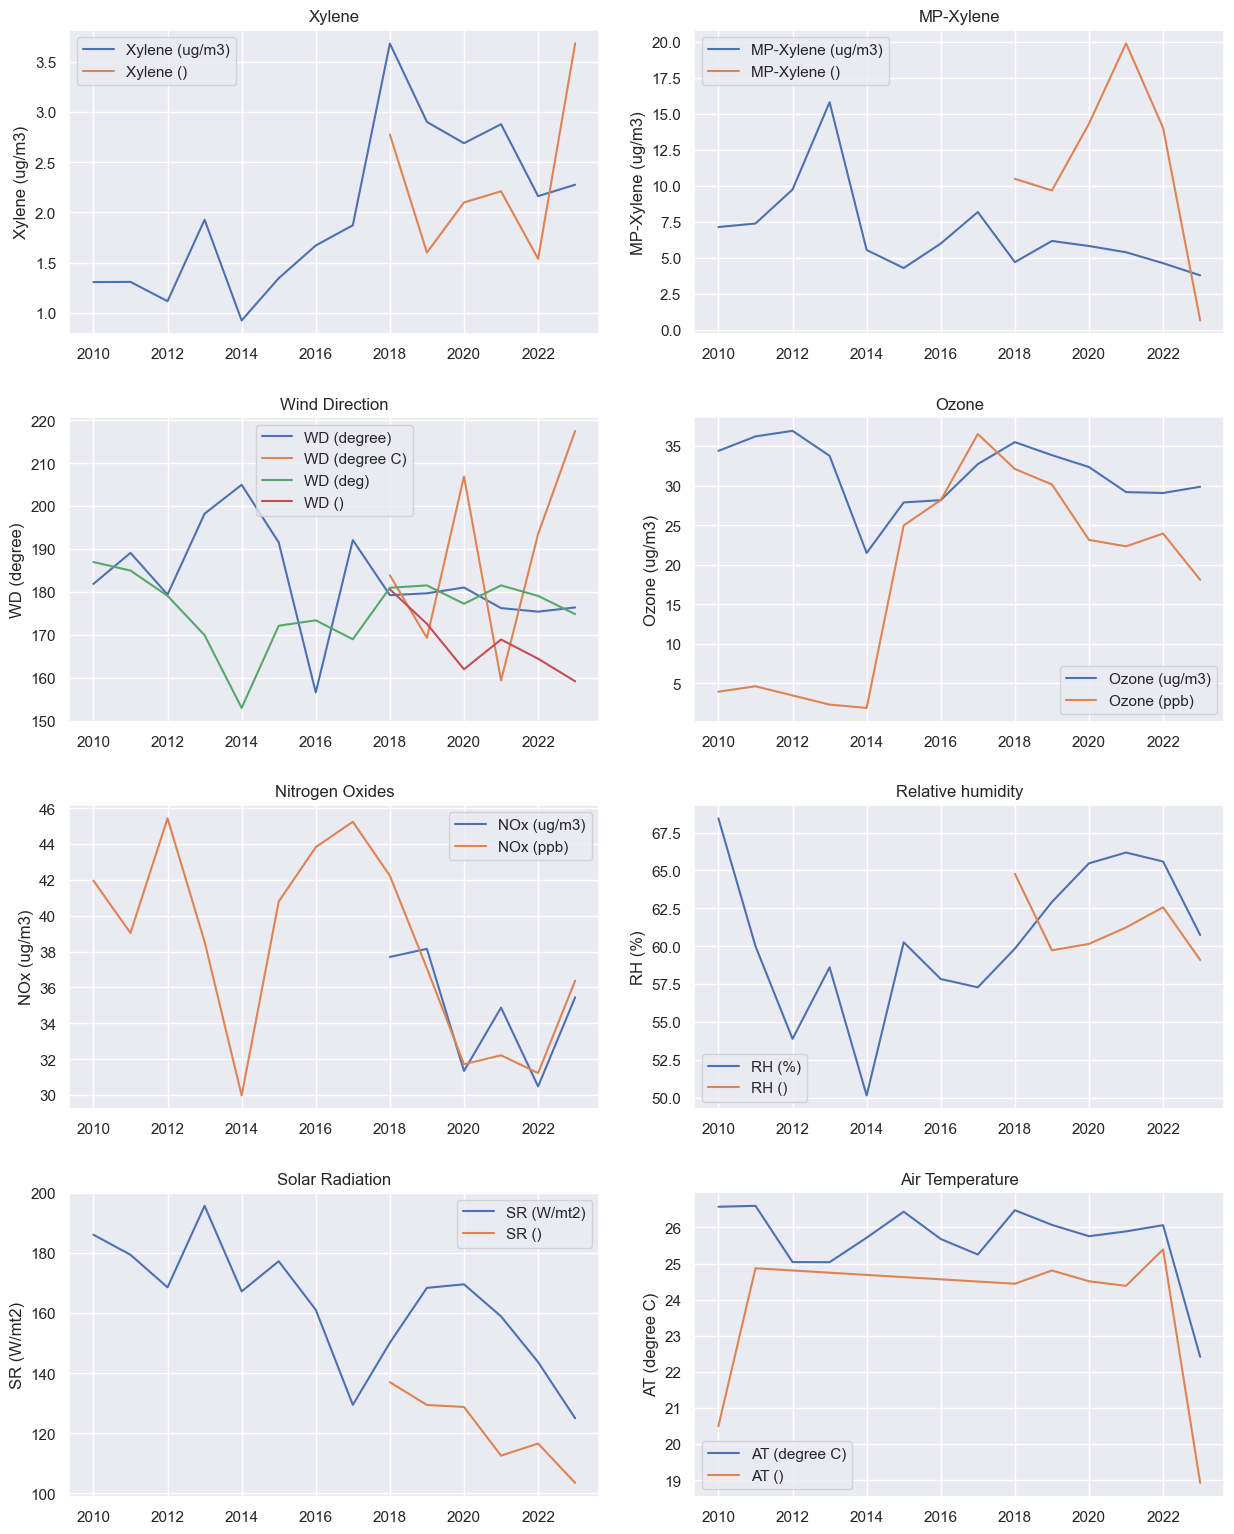

In [9]:
groups = {
    'Xylene':            ['Xylene (ug/m3)', 'Xylene ()'],
    "MP-Xylene":         ['MP-Xylene (ug/m3)', 'MP-Xylene ()'],
    'Wind Direction':   ["WD (degree)", "WD (degree C)", "WD (deg)", "WD ()"],
    'Ozone':             ['Ozone (ug/m3)', 'Ozone (ppb)'],
    'Nitrogen Oxides':   ['NOx (ug/m3)', 'NOx (ppb)'],
    'Relative humidity':  ['RH (%)', 'RH ()'],
    'Solar Radiation': ['SR (W/mt2)', 'SR ()'],
    'Air Temperature':  ['AT (degree C)', 'AT ()']
}

plot_feature_similarities(df_india, groups, columns=2)

Procediamo quindi con l’analisi descrittiva delle variabili raggruppate. Dopo aver raccolto in un’unica lista tutte le feature interessate, calcolo per ciascuna statistica di base — media, deviazione standard, valori minimo e massimo — formattando i risultati con tre decimali per migliorarne la leggibilità. Questo step permette di valutare rapidamente la scala e la distribuzione delle variabili, facilitando le decisioni su eventuali fusioni o eliminazioni di feature.


In [10]:
all_groups = [item for sublist in list(groups.values()) for item in sublist]
df_india[all_groups].describe().map(lambda x: f"{x:0.3f}")

Xylene (ug/m3)  Xylene () MP-Xylene (ug/m3) MP-Xylene ()  WD (degree)  \
count    3067546.000  65551.000       4004261.000    29205.000  5786055.000   
mean           2.501      2.022             5.339       13.824      177.479   
std            8.987      2.942            17.711       19.986       85.831   
min            0.000      0.000             0.010        0.010        0.010   
25%            0.060      0.170             0.440        2.890      107.500   
50%            0.520      1.250             1.450        7.040      178.340   
75%            2.140      3.040             4.280       15.760      248.310   
max          499.990    231.000           499.990      286.010      360.000   

      WD (degree C)     WD (deg)       WD () Ozone (ug/m3) Ozone (ppb)  \
count    131323.000  3989439.000  162542.000  10376088.000   47576.000   
mean        182.442      177.540     168.014        31.076      25.864   
std          97.961       88.393      92.331        31.011      19.535   
min           0.800        0.010       1.000         0.010       0.050   
25%          90.050      108.000      95.350         9.550      13.530   
50%         181.330      178.040     164.350        20.700      20.480   
75%         276.600      250.750     246.600        41.830      33.130   
max         359.000      360.000     359.700       200.000     198.470   

      NOx (ug/m3)     NOx (ppb)       RH (%)       RH ()   SR (W/mt2)  \
count  450067.000  10676795.000  9328387.000  182794.000  8248522.000   
mean       34.366        34.872       63.425      61.211      155.517   
std        40.213        47.093       23.298      18.156      210.047   
min         0.000         0.000        0.010       0.820        0.000   
25%        13.280        11.140       46.860      49.900        8.500   
50%        22.630        20.790       65.880      61.250       47.880   
75%        39.670        38.710       82.250      71.250      241.750   
max       498.850       500.000      100.000     100.000     1995.000   

            SR () AT (degree C)       AT ()  
count  126670.000   6149927.000  170546.000  
mean      123.145        25.652      24.244  
std       182.783         7.140       7.802  
min         0.500         0.100       0.200  
25%         7.000        21.380      18.520  
50%        19.090        26.290      25.000  
75%       181.100        30.280      29.750  
max      1280.700        60.000      56.270

Dopo aver esaminato in dettaglio la tabella, avvio la riduzione delle colonne duplicate aggregando quelle che rappresentano la stessa variabile con nomi diversi. Per farlo definisco un dizionario in cui ogni chiave è il nome unificato della variabile e i valori sono le etichette alternative. La funzione itera sul dizionario, trasferendo i valori non nulli dalle colonne secondarie a quella principale e cancellando infine le colonne ridondanti. Questo passaggio semplifica il dataset, eliminando le duplicazioni e facilitando le analisi future.

In [11]:
reduction_groups = {
    "Xylene (ug/m3)":    ["Xylene ()"],
    "MP-Xylene (ug/m3)": ["MP-Xylene ()"],
    "Benzene (ug/m3)":   ["Benzene ()"],
    "Toluene (ug/m3)":   ["Toluene ()"],
    "SO2 (ug/m3)":       ["SO2 ()"],
    "NOx (ug/m3)":       ["NOx (ppb)"],
    "Ozone (ug/m3)":     ["Ozone (ppb)"],
    "AT (degree C)":     ["AT ()"],
    "WD (degree)":       ["WD (degree C)", "WD (deg)", "WD ()"],
    "WS (m/s)":          ["WS ()"]
}

In [12]:
def merge_columns(dataframe, columns):
    for column, cols_to_merge in columns.items():
        if column not in dataframe.columns and any(name in dataframe.columns for name in cols_to_merge):
            dataframe[column] = np.nan

        for col_name in cols_to_merge:
            if col_name in dataframe.columns:
                dataframe[column] = dataframe[column].fillna(dataframe[col_name])
                dataframe = dataframe.drop(columns=[col_name])

    return dataframe

In [13]:
df_india = merge_columns(df_india, reduction_groups)

### Verifica dei valori mancanti

Il primo passo consiste nel quantificare quanti dati mancanti siano presenti per ciascuna delle feature selezionate.

In [14]:
df_india.isnull().sum().sort_values(ascending=False)

Eth-Benzene ()    14295663
Gust (km/hr)      14295663
Power (W)         14295663
CO2 (mg/m3)       14295663
Gust (kl/h)       14295663
                    ...   
NO (ug/m3)         3501917
NOx (ug/m3)        3168801
NO2 (ug/m3)        3111384
city                     0
state                    0
Length: 85, dtype: int64

In [15]:
df_india = df_india.dropna(how='all')
df_india = df_india.dropna(how='all', axis='columns')

In [16]:
def get_null_info(dataframe):
    null_vals = dataframe.isnull().sum()

    df_null_vals = pd.concat({'Null Count': null_vals,
                              'Percentage of Missing Values (%)': round(null_vals * 100 / len(dataframe), 2)}, axis=1)

    return df_null_vals.sort_values(by=['Null Count'], ascending=False)

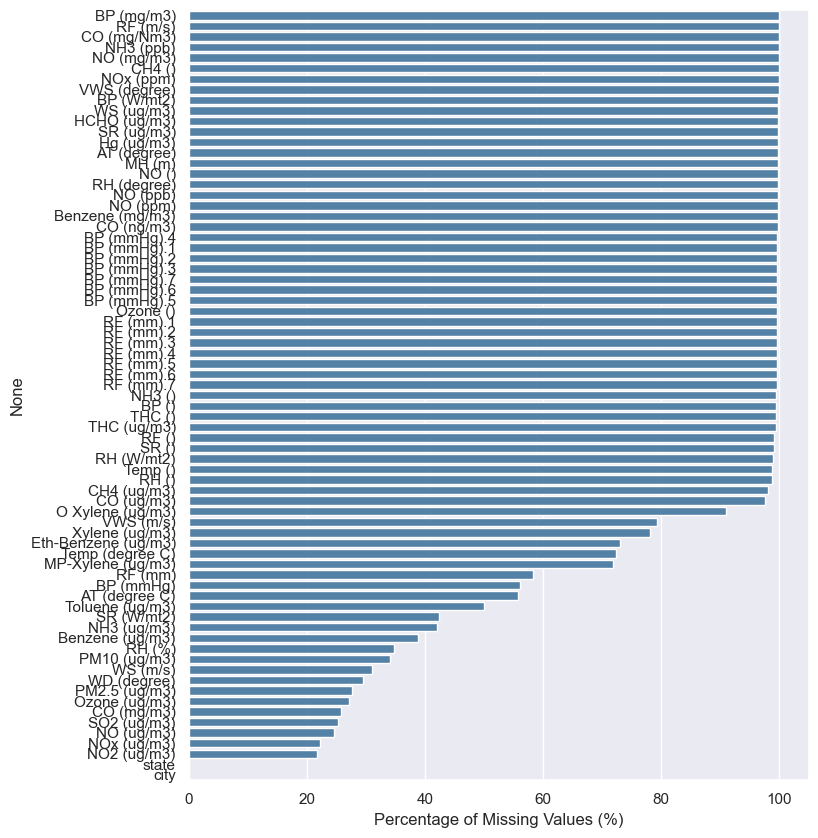

PM2.5 (ug/m3)  PM10 (ug/m3)  NO (ug/m3)  NO2 (ug/m3)  \
datetime                                                                    
2016-07-01 10:00:00          10.67          39.0       17.67         39.2   
2016-07-01 11:00:00           2.00          39.0       20.50         41.9   
2016-07-01 12:00:00            NaN           NaN         NaN          NaN   
2016-07-01 13:00:00            NaN           NaN         NaN          NaN   
2016-07-01 14:00:00          20.50          50.0       15.40         43.6   

                     NH3 (ug/m3)  SO2 (ug/m3)  CO (mg/m3)  Ozone (ug/m3)  \
datetime                                                                   
2016-07-01 10:00:00         7.07         6.60        0.48           14.5   
2016-07-01 11:00:00         7.40          NaN        0.49           15.0   
2016-07-01 12:00:00          NaN          NaN         NaN            NaN   
2016-07-01 13:00:00          NaN          NaN         NaN            NaN   
2016-07-01 14:00:00         6.35         6.38        0.47           10.5   

                     Benzene (ug/m3)  Toluene (ug/m3)  Temp (degree C)  \
datetime                                                                 
2016-07-01 10:00:00              1.0             4.63            33.43   
2016-07-01 11:00:00              0.7             4.50            33.70   
2016-07-01 12:00:00              NaN              NaN              NaN   
2016-07-01 13:00:00              NaN              NaN              NaN   
2016-07-01 14:00:00              0.6             4.50            33.57   

                     RH (%)  WS (m/s)  SR (W/mt2)  BP (mmHg)  VWS (m/s)  \
datetime                                                                  
2016-07-01 10:00:00   71.67      2.30      123.67        NaN       -0.1   
2016-07-01 11:00:00   70.00      2.50      186.00        NaN       -0.1   
2016-07-01 12:00:00     NaN       NaN         NaN        NaN        NaN   
2016-07-01 13:00:00     NaN       NaN         NaN        NaN        NaN   
2016-07-01 14:00:00   63.50      1.88      240.50        NaN       -0.1   

                     Xylene (ug/m3)  RF (mm)  AT (degree C)      city  \
datetime                                                                
2016-07-01 10:00:00             0.1      0.0          23.05  Tirupati   
2016-07-01 11:00:00             0.1      0.0            NaN  Tirupati   
2016-07-01 12:00:00             NaN      NaN            NaN  Tirupati   
2016-07-01 13:00:00             NaN      NaN            NaN  Tirupati   
2016-07-01 14:00:00             0.1      0.0            NaN  Tirupati   

                              state  Eth-Benzene (ug/m3)  MP-Xylene (ug/m3)  \
datetime                                                                      
2016-07-01 10:00:00  Andhra Pradesh                  NaN                NaN   
2016-07-01 11:00:00  Andhra Pradesh                  NaN                NaN   
2016-07-01 12:00:00  Andhra Pradesh                  NaN                NaN   
2016-07-01 13:00:00  Andhra Pradesh                  NaN                NaN   
2016-07-01 14:00:00  Andhra Pradesh                  NaN                NaN   

                     O Xylene (ug/m3)  VWS (degree)  WD (degree)  Temp ()  \
datetime                                                                    
2016-07-01 10:00:00               NaN           NaN       226.33      NaN   
2016-07-01 11:00:00               NaN           NaN       223.00      NaN   
2016-07-01 12:00:00               NaN           NaN          NaN      NaN   
2016-07-01 13:00:00               NaN           NaN          NaN      NaN   
2016-07-01 14:00:00               NaN           NaN       223.00      NaN   

                     RF ()  NO (mg/m3)  CO (mg/Nm3)  RF (m/s)  SR (ug/m3)  \
datetime                                                                    
2016-07-01 10:00:00    NaN         NaN          NaN       NaN         NaN   
2016-07-01 11:00:00    NaN         NaN          NaN       NaN     

In [17]:
df_india_null_info = get_null_info(df_india)

plt.figure(figsize=(8, 10))
sns.barplot(data=df_india_null_info, x='Percentage of Missing Values (%)', y=df_india_null_info.index, orient='h', color='steelblue')
plt.show()
df_india.head()

### Informazioni sul numero dei valori mancanti del dataset

Finora abbiamo analizzato solo un singolo stato. Potremmo avere una migliore percezione dei dati mancanti se analizzassimo l'intero Dataset.

In [18]:
df_india.head()

PM2.5 (ug/m3)  PM10 (ug/m3)  NO (ug/m3)  NO2 (ug/m3)  \
datetime                                                                    
2016-07-01 10:00:00          10.67          39.0       17.67         39.2   
2016-07-01 11:00:00           2.00          39.0       20.50         41.9   
2016-07-01 12:00:00            NaN           NaN         NaN          NaN   
2016-07-01 13:00:00            NaN           NaN         NaN          NaN   
2016-07-01 14:00:00          20.50          50.0       15.40         43.6   

                     NH3 (ug/m3)  SO2 (ug/m3)  CO (mg/m3)  Ozone (ug/m3)  \
datetime                                                                   
2016-07-01 10:00:00         7.07         6.60        0.48           14.5   
2016-07-01 11:00:00         7.40          NaN        0.49           15.0   
2016-07-01 12:00:00          NaN          NaN         NaN            NaN   
2016-07-01 13:00:00          NaN          NaN         NaN            NaN   
2016-07-01 14:00:00         6.35         6.38        0.47           10.5   

                     Benzene (ug/m3)  Toluene (ug/m3)  Temp (degree C)  \
datetime                                                                 
2016-07-01 10:00:00              1.0             4.63            33.43   
2016-07-01 11:00:00              0.7             4.50            33.70   
2016-07-01 12:00:00              NaN              NaN              NaN   
2016-07-01 13:00:00              NaN              NaN              NaN   
2016-07-01 14:00:00              0.6             4.50            33.57   

                     RH (%)  WS (m/s)  SR (W/mt2)  BP (mmHg)  VWS (m/s)  \
datetime                                                                  
2016-07-01 10:00:00   71.67      2.30      123.67        NaN       -0.1   
2016-07-01 11:00:00   70.00      2.50      186.00        NaN       -0.1   
2016-07-01 12:00:00     NaN       NaN         NaN        NaN        NaN   
2016-07-01 13:00:00     NaN       NaN         NaN        NaN        NaN   
2016-07-01 14:00:00   63.50      1.88      240.50        NaN       -0.1   

                     Xylene (ug/m3)  RF (mm)  AT (degree C)      city  \
datetime                                                                
2016-07-01 10:00:00             0.1      0.0          23.05  Tirupati   
2016-07-01 11:00:00             0.1      0.0            NaN  Tirupati   
2016-07-01 12:00:00             NaN      NaN            NaN  Tirupati   
2016-07-01 13:00:00             NaN      NaN            NaN  Tirupati   
2016-07-01 14:00:00             0.1      0.0            NaN  Tirupati   

                              state  Eth-Benzene (ug/m3)  MP-Xylene (ug/m3)  \
datetime                                                                      
2016-07-01 10:00:00  Andhra Pradesh                  NaN                NaN   
2016-07-01 11:00:00  Andhra Pradesh                  NaN                NaN   
2016-07-01 12:00:00  Andhra Pradesh                  NaN                NaN   
2016-07-01 13:00:00  Andhra Pradesh                  NaN                NaN   
2016-07-01 14:00:00  Andhra Pradesh                  NaN                NaN   

                     O Xylene (ug/m3)  VWS (degree)  WD (degree)  Temp ()  \
datetime                                                                    
2016-07-01 10:00:00               NaN           NaN       226.33      NaN   
2016-07-01 11:00:00               NaN           NaN       223.00      NaN   
2016-07-01 12:00:00               NaN           NaN          NaN      NaN   
2016-07-01 13:00:00               NaN           NaN          NaN      NaN   
2016-07-01 14:00:00               NaN           NaN       223.00      NaN   

                     RF ()  NO (mg/m3)  CO (mg/Nm3)  RF (m/s)  SR (ug/m3)  \
datetime                                                                    
2016-07-01 10:00:00    NaN         NaN          NaN       NaN         NaN   
2016-07-01 11:00:00    NaN         NaN          NaN       NaN     

In [19]:
def get_overall_ds_info():
    features = {}
    total_records = 0

    for i, state_name in enumerate(unique_states):
        clear_output(wait=False)

        temp_df = combine_state_df(state_name)
        temp_df = create_dt_index(temp_df)
        temp_df = temp_df.dropna(how='all')

        comparisons = get_null_info(temp_df)

        total_records += df_india.shape[0]

        for feature in comparisons.index:
            if feature in features:
                features[feature] += comparisons.loc[[feature]]['Null Count'].values[0]
            else:
                features[feature] = comparisons.loc[[feature]]['Null Count'].values[0]

    ds_null_info = pd.DataFrame.from_dict(features, orient='index', columns=['Null Count'])
    ds_null_info['Percentage of Missing Values (%)'] = round(ds_null_info['Null Count'] * 100 / total_records, 2)
    ds_null_info = ds_null_info.sort_values(by=['Null Count'], ascending=False)
    return ds_null_info

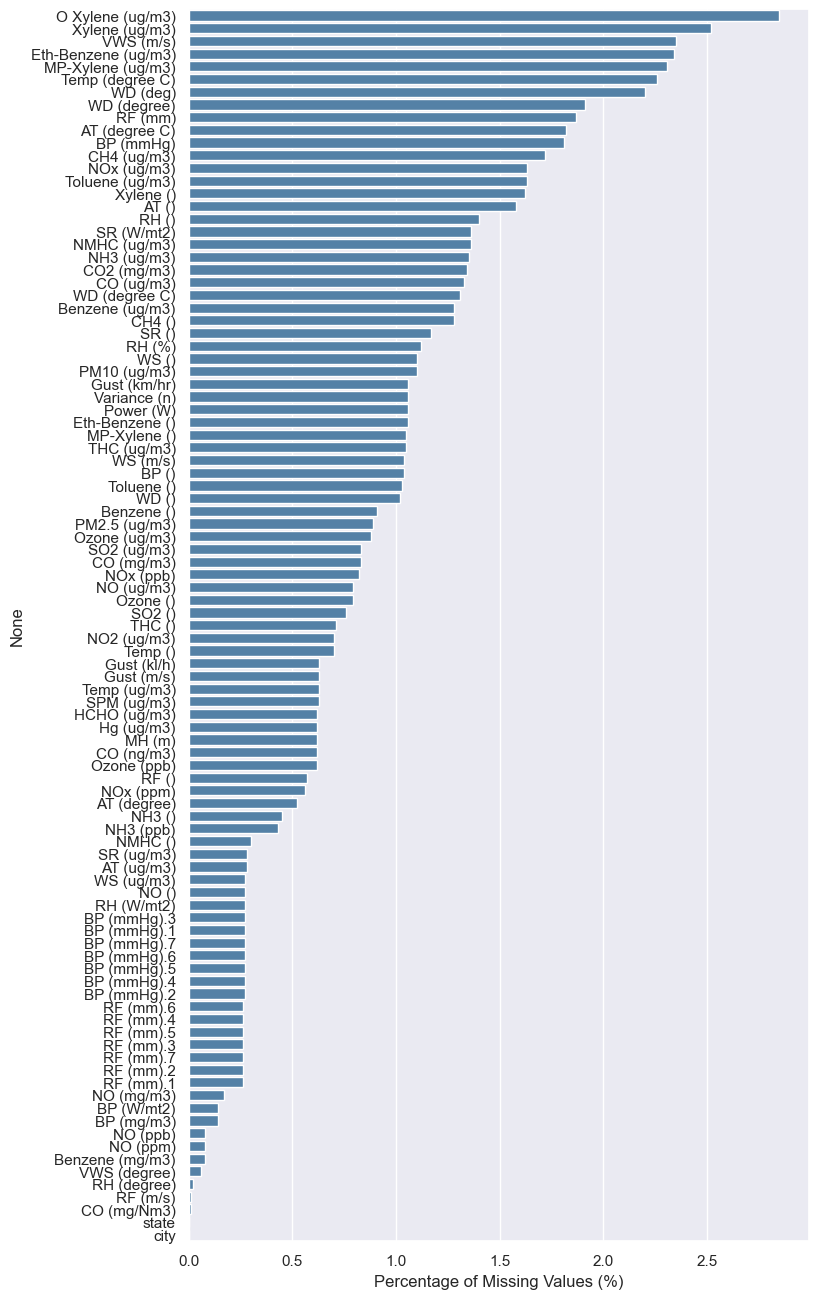

In [20]:
overall_ds_info = get_overall_ds_info()

plt.figure(figsize=(8, 16))
sns.barplot(data=overall_ds_info, x='Percentage of Missing Values (%)', y=overall_ds_info.index, orient='h', color='steelblue')
plt.show()

### Eliminare i valori mancanti per soglia

Tornando al dataframe della capitale Delhi, possiamo eliminare le colonne che contengono una certa soglia (cioè > 40%) di valori mancanti.

In [21]:
threshold = 0.6
df_india = df_india.dropna(thresh=df_india.shape[0]*threshold, axis=1)

In [22]:
get_null_info(df_india)

Null Count  Percentage of Missing Values (%)
Benzene (ug/m3)     5549529                             38.82
RH (%)              4967276                             34.75
PM10 (ug/m3)        4869779                             34.06
WS (m/s)            4431264                             31.00
WD (degree)         4226304                             29.56
PM2.5 (ug/m3)       3937969                             27.55
Ozone (ug/m3)       3871999                             27.09
CO (mg/m3)          3671011                             25.68
SO2 (ug/m3)         3616497                             25.30
NO (ug/m3)          3501917                             24.50
NOx (ug/m3)         3168801                             22.17
NO2 (ug/m3)         3111384                             21.76
city                      0                              0.00
state                     0                              0.00

### Analisi esplorativa dei dati

Sto raccogliendo le metriche iniziali in diversi gruppi. Ciò consentirà di effettuare confronti migliori.

In [23]:
pollutants = {
    'Particulate Matter' : ['PM2.5 (ug/m3)', 'PM10 (ug/m3)'],
    'Nitrogen Compounds' : ['NOx (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'NH3 (ug/m3)'],
    'Hydrocarbons' : ['Benzene (ug/m3)', 'Eth-Benzene (ug/m3)', 'Xylene (ug/m3)', 'MP-Xylene (ug/m3)', 'O Xylene (ug/m3)', 'Toluene (ug/m3)'],
    'Carbon Monoxide': ['CO (mg/m3)'],
    'Sulfur Dioxide': ['SO2 (ug/m3)'],
    'Ozone Concentration' : ['Ozone (ug/m3)']
}

other_metrics = {
    'Solar Radiation' : ['SR (W/mt2)'],
    'Temperatures' : ['Temp (degree C)', 'AT (degree C)'],
    'Relative Humidity' : ['RH (%)'],
    'Rainfall' : ['RF (mm)'],
    'Barometric Pressure' : ['BP (mmHg)'],
    'Wind Direction' : ['WD (degree)'],
    'Wind Speed' : ['WS (m/s)']
}

### Frequenze temporali

Cominciamo a raggruppare il nostro DataFrame per varie frequenze temporali.

In [24]:
slice_groups = {
    'Group by Day':   df_india.groupby(pd.Grouper(freq='1D')).mean(numeric_only=True),
    'Group by Month': df_india.groupby(pd.Grouper(freq='1ME')).mean(numeric_only=True),
    'Group by Year':  df_india.groupby(pd.Grouper(freq='1YE')).mean(numeric_only=True)
}

In [25]:
def plot_features_by_group(features, slice_groups):
    for feature in features:
        fig, ax = plt.subplots(1, 1, figsize=(12, 4))
        fig.suptitle(feature)

        labels = []
        for i, (group, group_df) in enumerate(slice_groups.items()):
            data_slice = group_df[group_df.columns.intersection(pollutants[feature])]

            if feature == "Nitrogen Compounds":
                data_slice = data_slice.drop(['NO (ug/m3)', 'NO2 (ug/m3)'], axis=1)

            data_slice.plot(kind="line", ax=ax)

            for column in data_slice.columns:
                labels.append(f'{column} [{group}]')

        ax.set(xlabel=None)
        ax.legend(labels)
        plt.plot()

PM2.5 (ug/m3)  PM10 (ug/m3)  NO (ug/m3)  NO2 (ug/m3)  \
datetime                                                                    
2016-07-01 10:00:00          10.67          39.0       17.67         39.2   
2016-07-01 11:00:00           2.00          39.0       20.50         41.9   
2016-07-01 12:00:00            NaN           NaN         NaN          NaN   
2016-07-01 13:00:00            NaN           NaN         NaN          NaN   
2016-07-01 14:00:00          20.50          50.0       15.40         43.6   

                     SO2 (ug/m3)  CO (mg/m3)  Ozone (ug/m3)  Benzene (ug/m3)  \
datetime                                                                       
2016-07-01 10:00:00         6.60        0.48           14.5              1.0   
2016-07-01 11:00:00          NaN        0.49           15.0              0.7   
2016-07-01 12:00:00          NaN         NaN            NaN              NaN   
2016-07-01 13:00:00          NaN         NaN            NaN              NaN   
2016-07-01 14:00:00         6.38        0.47           10.5              0.6   

                     RH (%)  WS (m/s)      city           state  WD (degree)  \
datetime                                                                       
2016-07-01 10:00:00   71.67      2.30  Tirupati  Andhra Pradesh       226.33   
2016-07-01 11:00:00   70.00      2.50  Tirupati  Andhra Pradesh       223.00   
2016-07-01 12:00:00     NaN       NaN  Tirupati  Andhra Pradesh          NaN   
2016-07-01 13:00:00     NaN       NaN  Tirupati  Andhra Pradesh          NaN   
2016-07-01 14:00:00   63.50      1.88  Tirupati  Andhra Pradesh       223.00   

                     NOx (ug/m3)  
datetime                          
2016-07-01 10:00:00        32.33  
2016-07-01 11:00:00        35.80  
2016-07-01 12:00:00          NaN  
2016-07-01 13:00:00          NaN  
2016-07-01 14:00:00        32.78

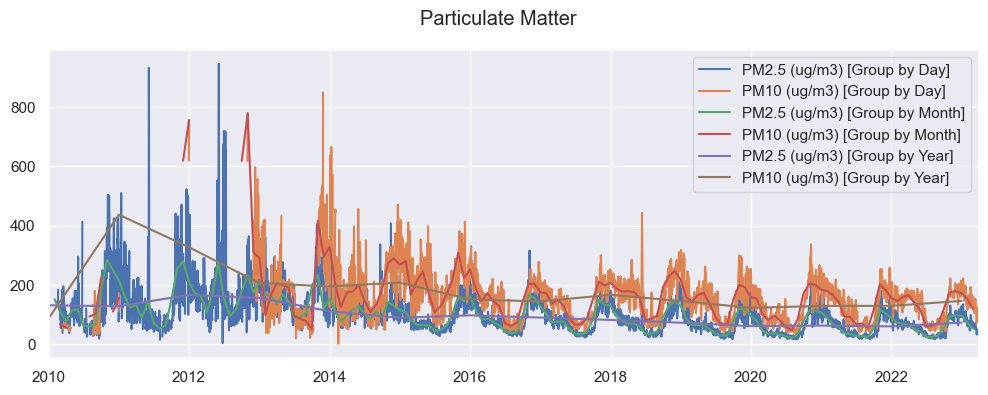

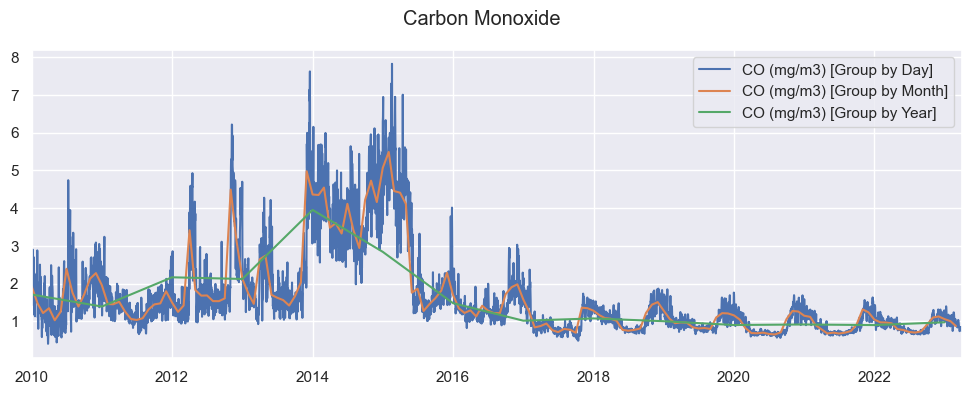

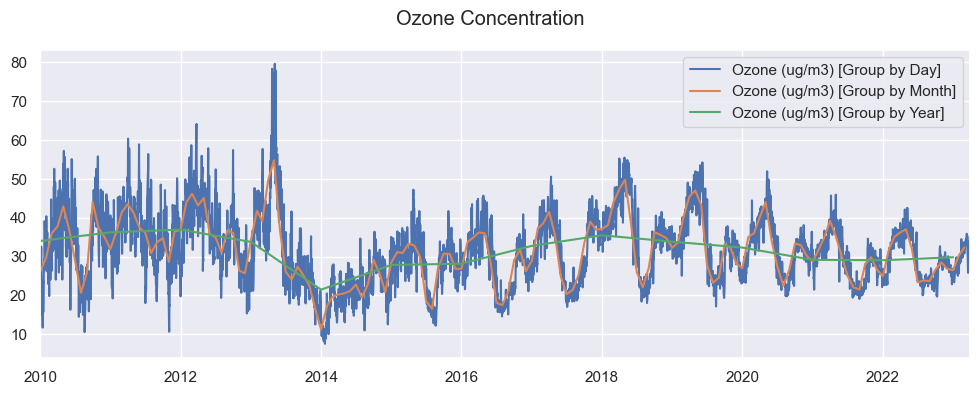

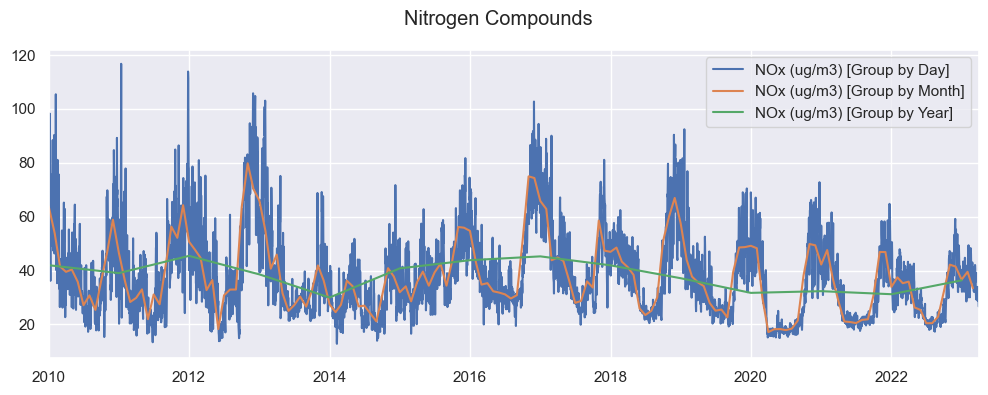

In [26]:
features_to_plot = ['Particulate Matter', 'Carbon Monoxide', 'Ozone Concentration', 'Nitrogen Compounds']
plot_features_by_group(features_to_plot, slice_groups)
df_india.head()

### Analisi stagionale su base annua
Dalle metriche selezionate emergono potenziali pattern di tipo stagionale. Per approfondire questa osservazione, eseguiamo un’analisi dettagliata delle variazioni stagionali nell’arco di un anno. Come punto di partenza, prenderemo in considerazione un sottoinsieme di dati relativo al periodo 2019–2020.

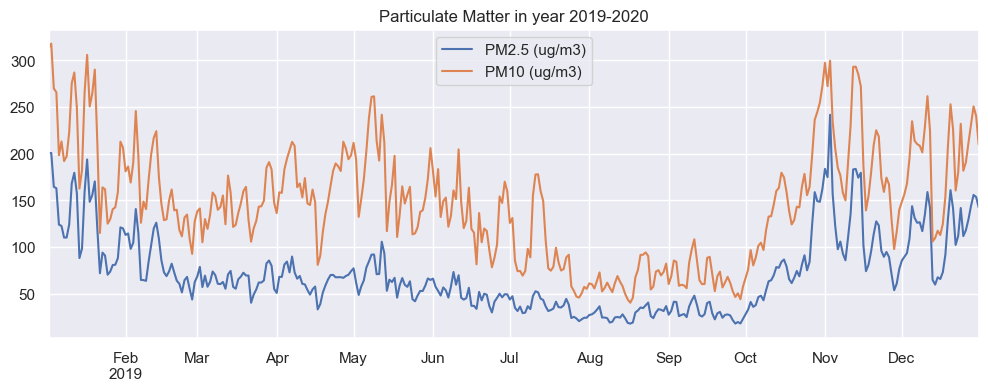

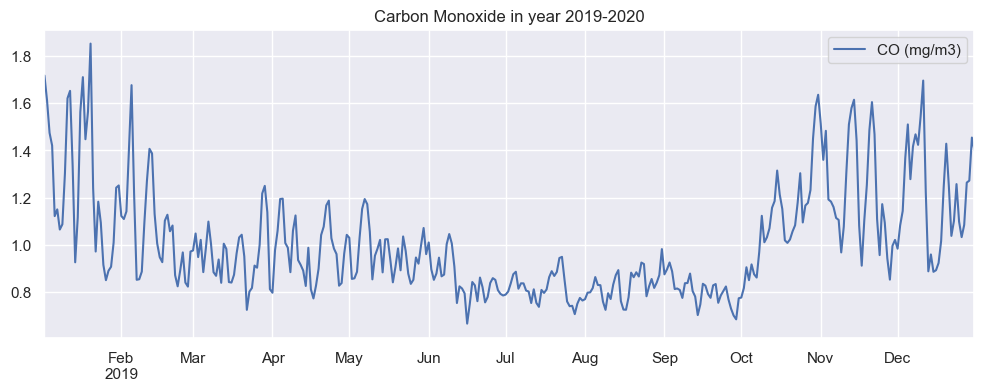

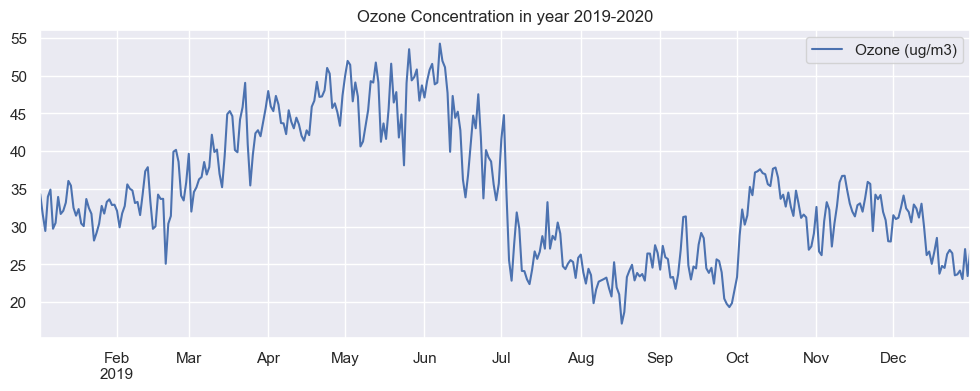

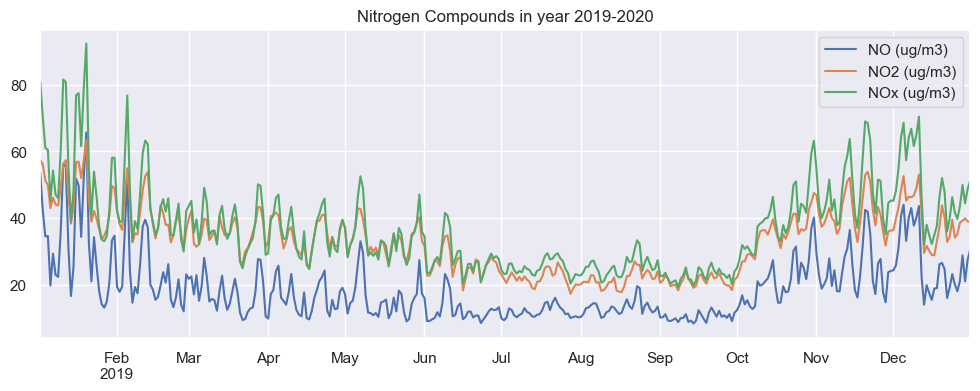

In [27]:
for feature in features_to_plot:
    data_slice = slice_groups['Group by Day'][slice_groups['Group by Day'].columns.intersection(pollutants[feature])]
    data_slice.query('datetime > 2019 and datetime < 2020').plot(title=f'{feature} in year 2019-2020', figsize=(12,4)).set(xlabel=None)

Si osserva un incremento nei valori di `Particulate Matter`, `Nitrogen Compounds` e `Carbon Monoxide` a partire da ottobre, con un picco che tende a persistere fino circa a marzo. Al contrario, la `Ozone Concentration` mostra un comportamento opposto, raggiungendo i valori massimi indicativamente tra maggio e giugno.

### PairPlot
Andiamo ad utilizzare il grafico a coppie, che ci consente di visualizzare in modo più chiaro le relazioni bivariate tra le variabili, nonché la distribuzione univariata di ciascuna di esse.

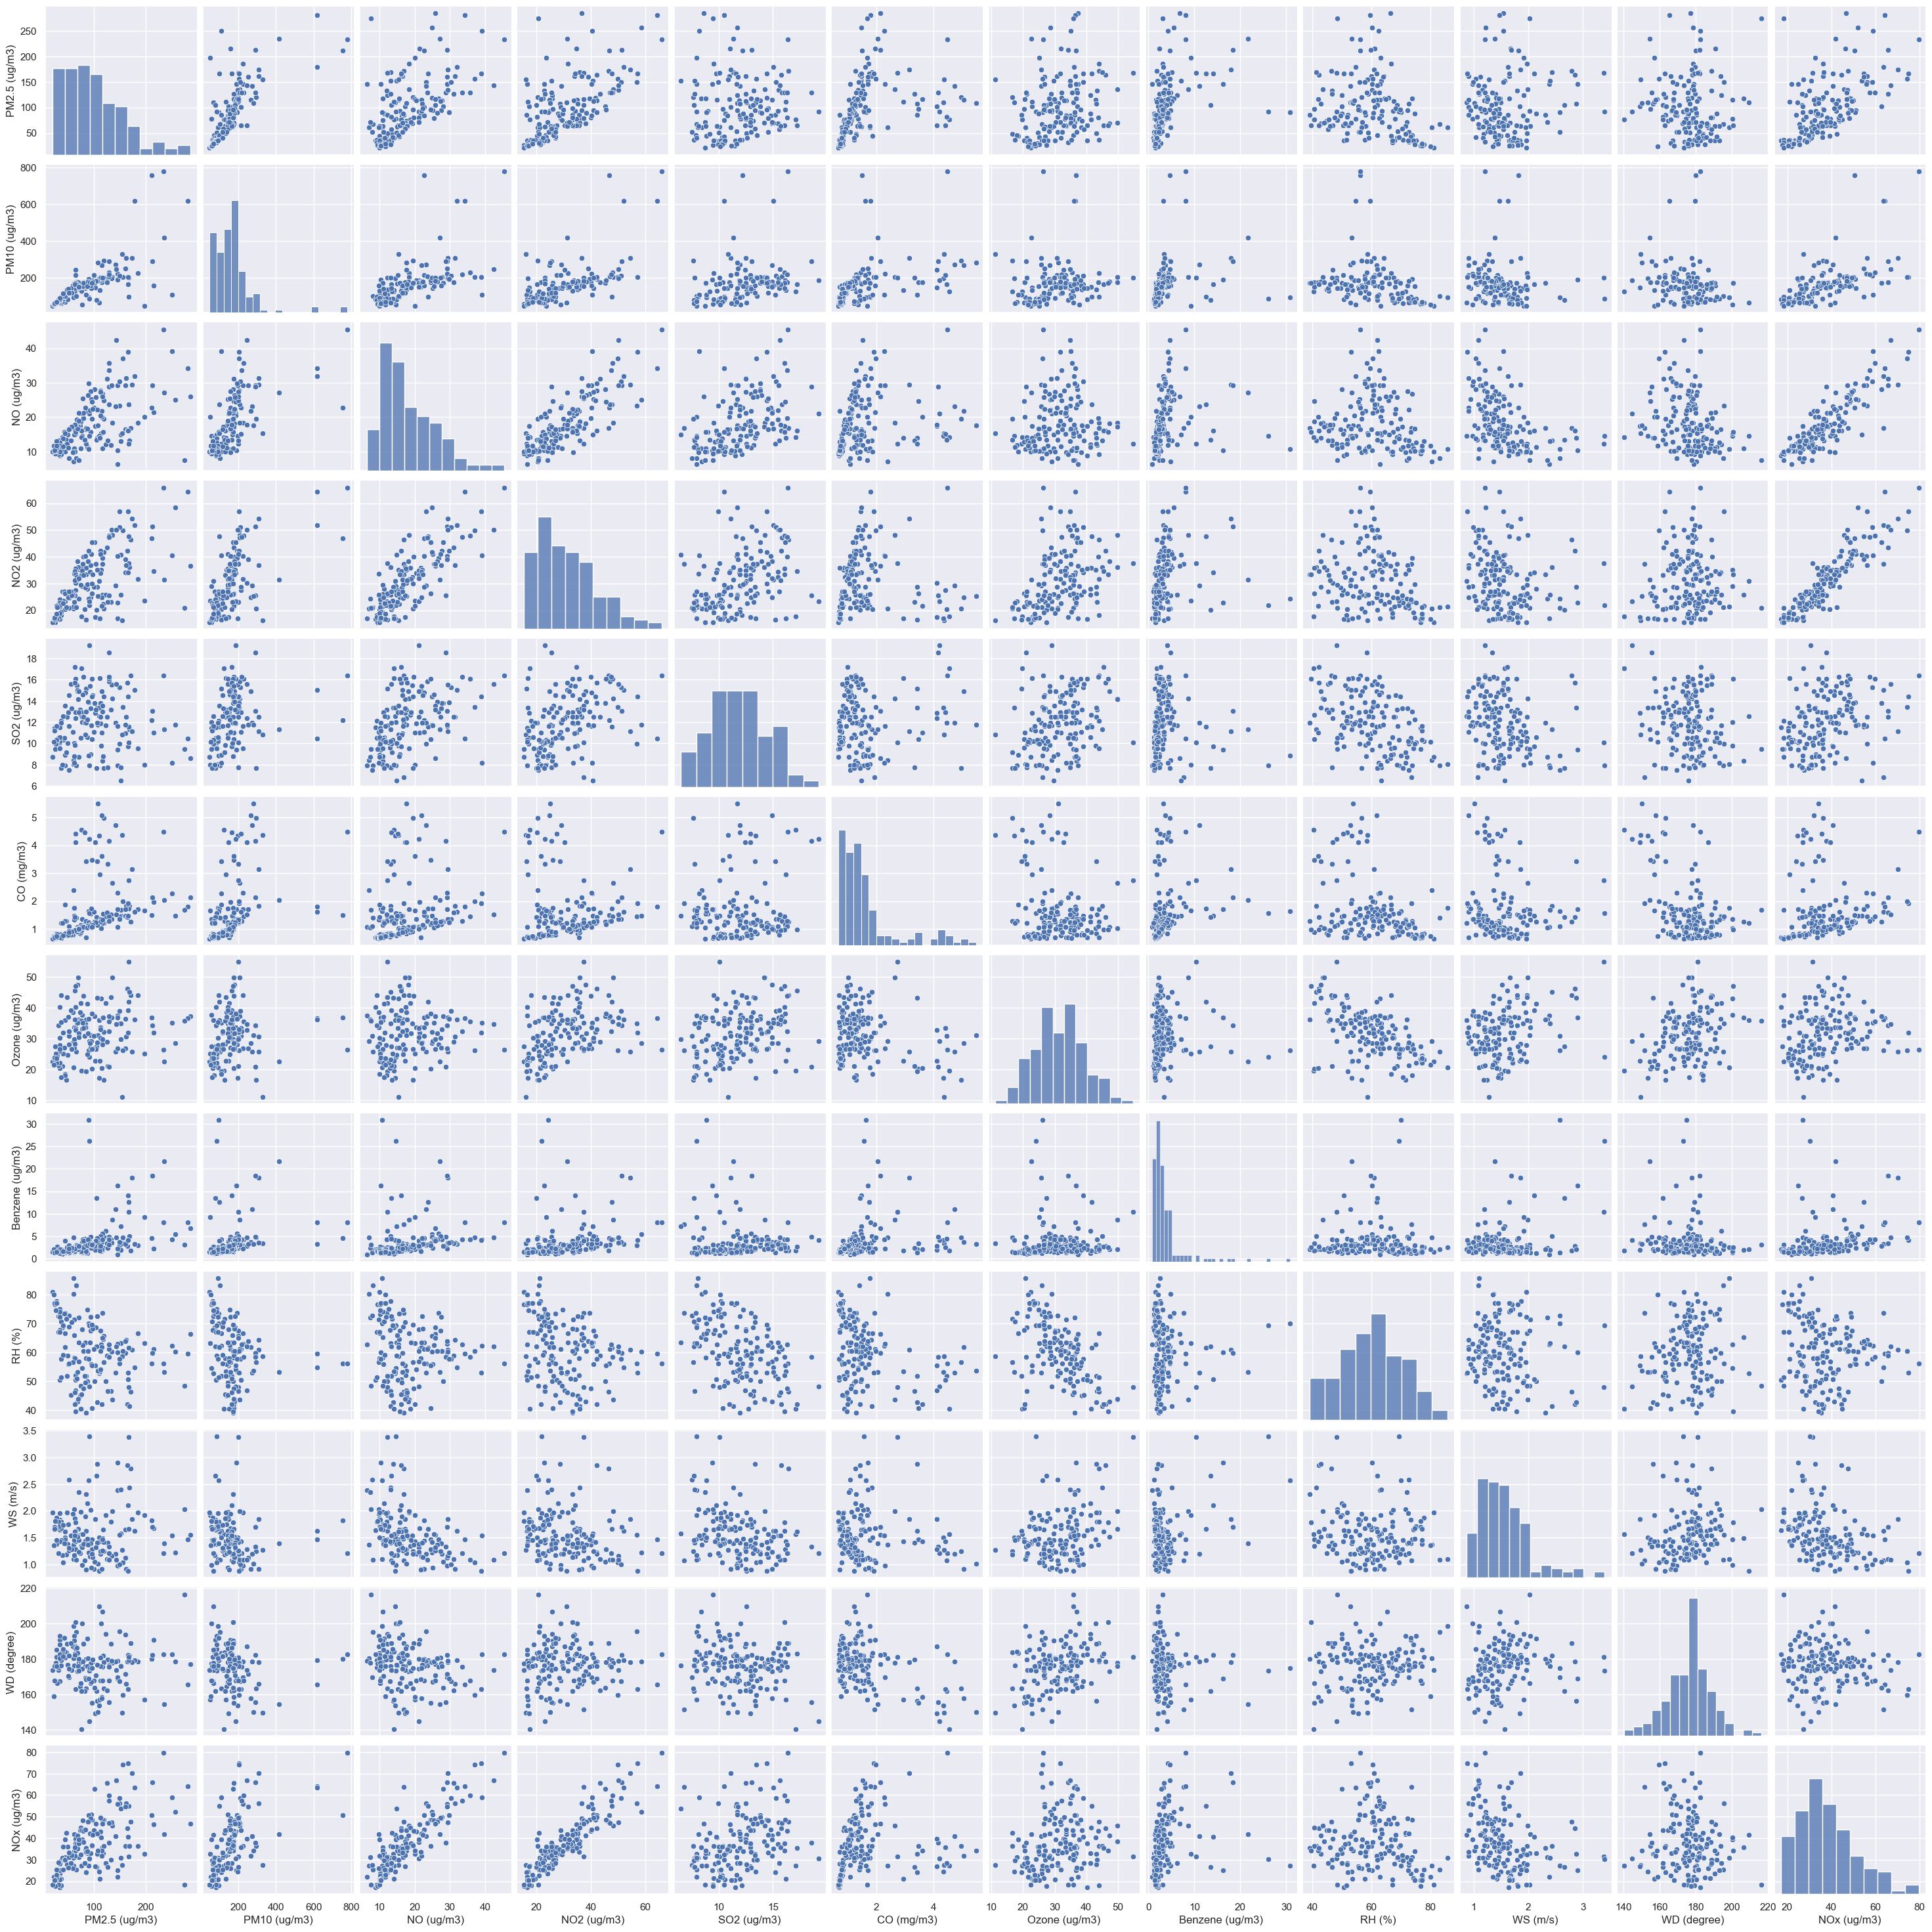

In [28]:
sns.pairplot(slice_groups['Group by Month'])

È evidente una correlazione lineare significativa tra `NOx`, `NO` e `NO2`. Considerando questa relazione, può essere opportuno mantenere esclusivamente la variabile aggregata `NOx` come rappresentazione generale del gruppo.

### Matrice di correlazione
Ora, andiamo ad utilizzare la matrice di correlazione che offre una rappresentazione sintetica ed efficace del grado di associazione lineare tra le diverse variabili del dataset.

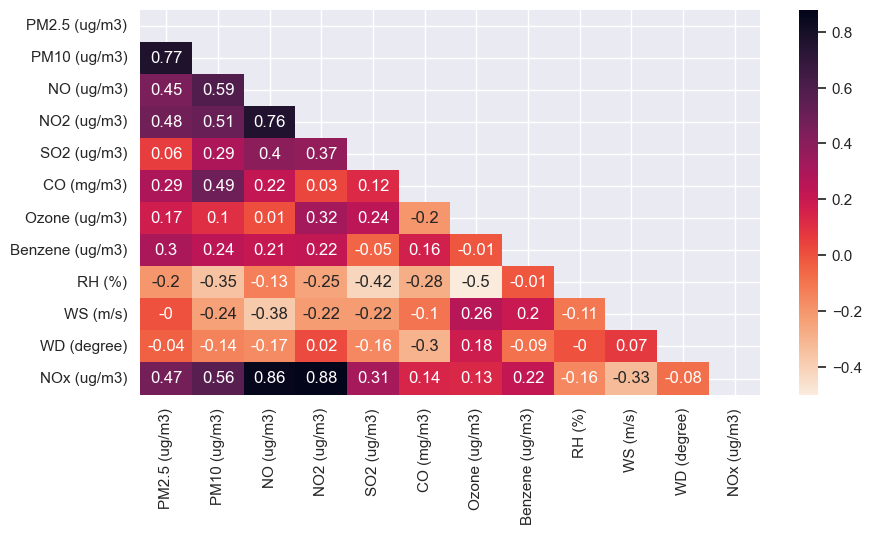

In [29]:
corr = slice_groups['Group by Day'].corr(numeric_only=True).round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10,5))
sns.heatmap(data=corr, mask=mask, annot=True, cmap="rocket_r")
plt.show()

In [30]:
corr_target = abs(corr['PM2.5 (ug/m3)'])
relevant_features = corr_target[corr_target>0.4]
relevant_features.sort_values(ascending=False)
df_india.head()

PM2.5 (ug/m3)  PM10 (ug/m3)  NO (ug/m3)  NO2 (ug/m3)  \
datetime                                                                    
2016-07-01 10:00:00          10.67          39.0       17.67         39.2   
2016-07-01 11:00:00           2.00          39.0       20.50         41.9   
2016-07-01 12:00:00            NaN           NaN         NaN          NaN   
2016-07-01 13:00:00            NaN           NaN         NaN          NaN   
2016-07-01 14:00:00          20.50          50.0       15.40         43.6   

                     SO2 (ug/m3)  CO (mg/m3)  Ozone (ug/m3)  Benzene (ug/m3)  \
datetime                                                                       
2016-07-01 10:00:00         6.60        0.48           14.5              1.0   
2016-07-01 11:00:00          NaN        0.49           15.0              0.7   
2016-07-01 12:00:00          NaN         NaN            NaN              NaN   
2016-07-01 13:00:00          NaN         NaN            NaN              NaN   
2016-07-01 14:00:00         6.38        0.47           10.5              0.6   

                     RH (%)  WS (m/s)      city           state  WD (degree)  \
datetime                                                                       
2016-07-01 10:00:00   71.67      2.30  Tirupati  Andhra Pradesh       226.33   
2016-07-01 11:00:00   70.00      2.50  Tirupati  Andhra Pradesh       223.00   
2016-07-01 12:00:00     NaN       NaN  Tirupati  Andhra Pradesh          NaN   
2016-07-01 13:00:00     NaN       NaN  Tirupati  Andhra Pradesh          NaN   
2016-07-01 14:00:00   63.50      1.88  Tirupati  Andhra Pradesh       223.00   

                     NOx (ug/m3)  
datetime                          
2016-07-01 10:00:00        32.33  
2016-07-01 11:00:00        35.80  
2016-07-01 12:00:00          NaN  
2016-07-01 13:00:00          NaN  
2016-07-01 14:00:00        32.78

Il grafico evidenzia diverse correlazioni significative tra le variabili. In particolare:

- `NOx` mostra una forte correlazione con le variabili `NO` e `NO2`.
- È inoltre evidente una relazione positiva tra `PM2.5` e `NOx`, suggerendo che all’aumentare dei valori di `NOx`, tendono ad aumentare anche i livelli di `PM2.5`.

## Feature Engineering

### Eliminazione delle Feature correlate

In [31]:
df_india = df_india.drop(['NO (ug/m3)', 'NO2 (ug/m3)'], axis=1)
df_india.head()

PM2.5 (ug/m3)  PM10 (ug/m3)  SO2 (ug/m3)  CO (mg/m3)  \
datetime                                                                    
2016-07-01 10:00:00          10.67          39.0         6.60        0.48   
2016-07-01 11:00:00           2.00          39.0          NaN        0.49   
2016-07-01 12:00:00            NaN           NaN          NaN         NaN   
2016-07-01 13:00:00            NaN           NaN          NaN         NaN   
2016-07-01 14:00:00          20.50          50.0         6.38        0.47   

                     Ozone (ug/m3)  Benzene (ug/m3)  RH (%)  WS (m/s)  \
datetime                                                                
2016-07-01 10:00:00           14.5              1.0   71.67      2.30   
2016-07-01 11:00:00           15.0              0.7   70.00      2.50   
2016-07-01 12:00:00            NaN              NaN     NaN       NaN   
2016-07-01 13:00:00            NaN              NaN     NaN       NaN   
2016-07-01 14:00:00           10.5              0.6   63.50      1.88   

                         city           state  WD (degree)  NOx (ug/m3)  
datetime                                                                 
2016-07-01 10:00:00  Tirupati  Andhra Pradesh       226.33        32.33  
2016-07-01 11:00:00  Tirupati  Andhra Pradesh       223.00        35.80  
2016-07-01 12:00:00  Tirupati  Andhra Pradesh          NaN          NaN  
2016-07-01 13:00:00  Tirupati  Andhra Pradesh          NaN          NaN  
2016-07-01 14:00:00  Tirupati  Andhra Pradesh       223.00        32.78

### Resampling
Poiché il dataframe combinato include misurazioni provenienti da diverse località all'interno dello stesso stato e riferite agli stessi intervalli temporali, è possibile che si verifichino duplicazioni temporali. Dal momento che l’obiettivo è analizzare la qualità dell’aria a livello statale, procederemo con un ricampionamento temporale aggregando i dati mediante media delle misurazioni corrispondenti allo stesso timestamp.

In [ ]:
df_resampled = (
    df_india
    .groupby('state')
    .resample('60min')
    .mean(numeric_only=True)
    .reset_index()
)
df_resampled = df_resampled.set_index('datetime')
df_india=df_resampled.copy()

### Isolation Forest - Rilevamento e Rimozione degli Outlier
In questa sequenza di celle utilizzeremo l'algoritmo Isolation Forest per identificare e rimuovere gli outlier, che rappresentano valori anomali che si discostano in modo significativo dalla distribuzione generale dei dati. La loro presenza può compromettere l’accuratezza delle analisi statistiche e influenzare negativamente le prestazioni dei modelli predittivi. L’identificazione e la rimozione degli outlier consente di ottenere risultati più affidabili e modelli previsionali più robusti.

Definiamo le colonne su cui vogliamo applicare l'Isolation Forest.

In [33]:
features = ['PM2.5 (ug/m3)', 'CO (mg/m3)', 'Ozone (ug/m3)', 'NOx (ug/m3)']
df_india_features = df_india[features].copy()

Creiamo il modello specificando la proporzione di outlier attesi (`contamination`).

In [34]:
iso = IsolationForest(contamination=0.01, random_state=42)
iso.fit(df_india_features)

IsolationForest(contamination=0.01, random_state=42)

Usiamo il metodo `predict` per assegnare -1 agli outlier e 1 ai punti normali.

In [35]:
df_india['anomaly'] = iso.predict(df_india_features)

Creiamo un nuovo DataFrame senza gli outlier identificati.

In [36]:
df_india_clean = df_india[df_india['anomaly'] == 1].drop(columns='anomaly')

Confrontiamo la distribuzione originale e quella ripulita per ogni feature.

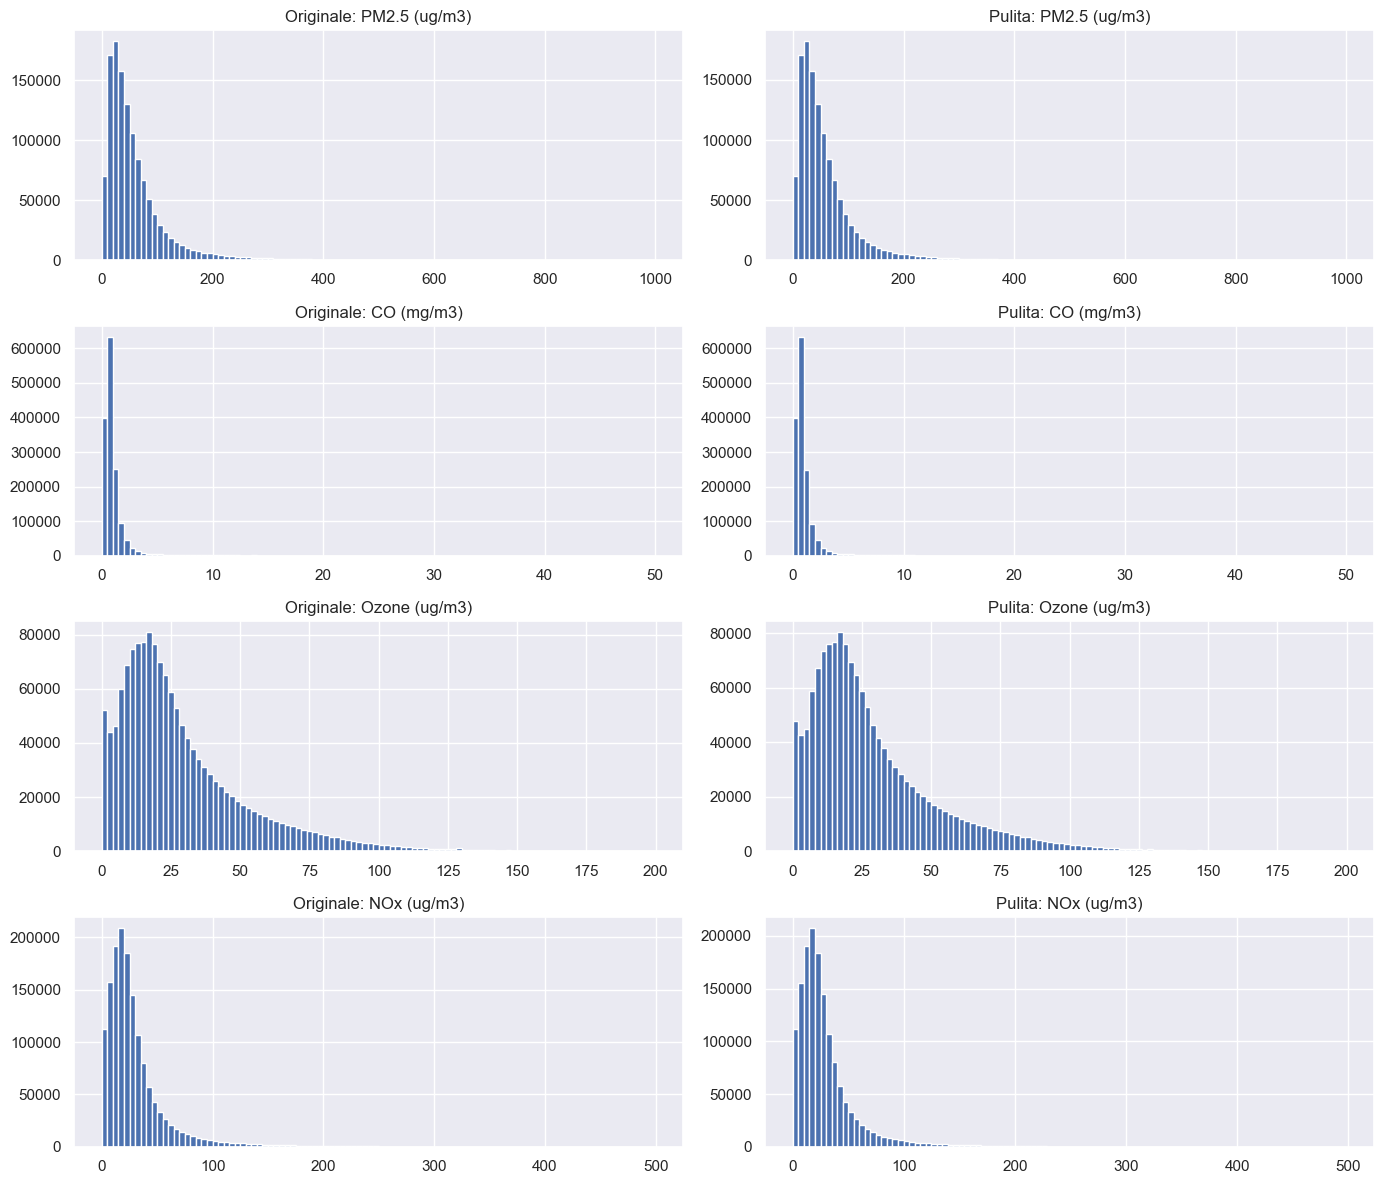

state  PM2.5 (ug/m3)  PM10 (ug/m3)  SO2 (ug/m3)  \
datetime                                                                        
2016-07-01 10:00:00  Andhra Pradesh          10.67          39.0         6.60   
2016-07-01 11:00:00  Andhra Pradesh           2.00          39.0          NaN   
2016-07-01 12:00:00  Andhra Pradesh            NaN           NaN          NaN   
2016-07-01 13:00:00  Andhra Pradesh            NaN           NaN          NaN   
2016-07-01 14:00:00  Andhra Pradesh          20.50          50.0         6.38   

                     CO (mg/m3)  Ozone (ug/m3)  Benzene (ug/m3)  RH (%)  \
datetime                                                                  
2016-07-01 10:00:00        0.48           14.5              1.0   71.67   
2016-07-01 11:00:00        0.49           15.0              0.7   70.00   
2016-07-01 12:00:00         NaN            NaN              NaN     NaN   
2016-07-01 13:00:00         NaN            NaN              NaN     NaN   
2016-07-01 14:00:00        0.47           10.5              0.6   63.50   

                     WS (m/s)  WD (degree)  NOx (ug/m3)  
datetime                                                 
2016-07-01 10:00:00      2.30       226.33        32.33  
2016-07-01 11:00:00      2.50       223.00        35.80  
2016-07-01 12:00:00       NaN          NaN          NaN  
2016-07-01 13:00:00       NaN          NaN          NaN  
2016-07-01 14:00:00      1.88       223.00        32.78

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(14, 12))
for i, col in enumerate(features):
    # distribuzione originale
    axes[i, 0].hist(df_india[col].dropna(), bins=100)
    axes[i, 0].set_title(f"Original: {col}")
    # distribuzione pulita
    axes[i, 1].hist(df_india_clean[col].dropna(), bins=100)
    axes[i, 1].set_title(f"Cleaned: {col}")
plt.tight_layout()
plt.show()

df_india = df_india_clean.copy()
df_india.head()

### Gestione dei valori mancanti

In [38]:
get_null_info(df_india)

Null Count  Percentage of Missing Values (%)
PM10 (ug/m3)         575345                             33.71
PM2.5 (ug/m3)        467560                             27.39
Benzene (ug/m3)      393217                             23.04
RH (%)               278222                             16.30
WS (m/s)             257281                             15.07
Ozone (ug/m3)        253360                             14.84
WD (degree)          252258                             14.78
NOx (ug/m3)          221289                             12.96
SO2 (ug/m3)          204391                             11.97
CO (mg/m3)           202137                             11.84
state                     0                              0.00

In [39]:
numeric_cols = df_india.select_dtypes(include='number').columns

df_india[numeric_cols] = df_india[numeric_cols].interpolate(method='pad')
df_india[numeric_cols] = df_india[numeric_cols].fillna(df_india[numeric_cols].mean())
df_india.info()

C:\Users\jacop\AppData\Local\Temp\ipykernel_11308\3869997435.py:3: FutureWarning: DataFrame.interpolate with method=pad is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_india[numeric_cols] = df_india[numeric_cols].interpolate(method='pad')


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1706891 entries, 2016-07-01 10:00:00 to 2023-03-31 23:00:00
Data columns (total 11 columns):
 #   Column           Dtype  
---  ------           -----  
 0   state            object 
 1   PM2.5 (ug/m3)    float64
 2   PM10 (ug/m3)     float64
 3   SO2 (ug/m3)      float64
 4   CO (mg/m3)       float64
 5   Ozone (ug/m3)    float64
 6   Benzene (ug/m3)  float64
 7   RH (%)           float64
 8   WS (m/s)         float64
 9   WD (degree)      float64
 10  NOx (ug/m3)      float64
dtypes: float64(10), object(1)
memory usage: 156.3+ MB


### Arricchimento del Dataset con Caratteristiche Aggiuntive
Procediamo con l'ampliamento del nostro dataset, integrando nuove features che possano risultare utili.

In [40]:
def create_features(df):
    df = df.copy()
    df['hour']       = df.index.hour
    df['dayofmonth'] = df.index.day
    df['dayofweek']  = df.index.dayofweek
    df['dayofyear']  = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week.astype("int64")
    df['month']      = df.index.month
    df['quarter']    = df.index.quarter
    df['year']       = df.index.year
    return df

In [41]:
date_features = ['hour', 'dayofmonth', 'dayofweek', 'dayofyear', 'weekofyear', 'month', 'quarter', 'year']
df_india = create_features(df_india)

In [42]:
pd.set_option('display.max_columns', None)
df_india.head()

state  PM2.5 (ug/m3)  PM10 (ug/m3)  SO2 (ug/m3)  \
datetime                                                                        
2016-07-01 10:00:00  Andhra Pradesh          10.67          39.0         6.60   
2016-07-01 11:00:00  Andhra Pradesh           2.00          39.0         6.60   
2016-07-01 12:00:00  Andhra Pradesh           2.00          39.0         6.60   
2016-07-01 13:00:00  Andhra Pradesh           2.00          39.0         6.60   
2016-07-01 14:00:00  Andhra Pradesh          20.50          50.0         6.38   

                     CO (mg/m3)  Ozone (ug/m3)  Benzene (ug/m3)  RH (%)  \
datetime                                                                  
2016-07-01 10:00:00        0.48           14.5              1.0   71.67   
2016-07-01 11:00:00        0.49           15.0              0.7   70.00   
2016-07-01 12:00:00        0.49           15.0              0.7   70.00   
2016-07-01 13:00:00        0.49           15.0              0.7   70.00   
2016-07-01 14:00:00        0.47           10.5              0.6   63.50   

                     WS (m/s)  WD (degree)  NOx (ug/m3)  hour  dayofmonth  \
datetime                                                                    
2016-07-01 10:00:00      2.30       226.33        32.33    10           1   
2016-07-01 11:00:00      2.50       223.00        35.80    11           1   
2016-07-01 12:00:00      2.50       223.00        35.80    12           1   
2016-07-01 13:00:00      2.50       223.00        35.80    13           1   
2016-07-01 14:00:00      1.88       223.00        32.78    14           1   

                     dayofweek  dayofyear  weekofyear  month  quarter  year  
datetime                                                                     
2016-07-01 10:00:00          4        183          26      7        3  2016  
2016-07-01 11:00:00          4        183          26      7        3  2016  
2016-07-01 12:00:00          4        183          26      7        3  2016  
2016-07-01 13:00:00          4        183          26      7        3  2016  
2016-07-01 14:00:00          4        183          26      7        3  2016

Ora, grazie alle features precedentemente descritte, è semplice visualizzare le diverse metriche. Ad esempio, possiamo esaminare la qualità dell'aria nel corso dei mesi utilizzando un boxplot.

In [43]:
def plot_by_datetime(metric, time_groups):
    for time_group in time_groups:
        fig, ax = plt.subplots(figsize=(12, 4))
        sns.boxplot(data=df_india, x=time_group, y=metric, hue=time_group, palette="icefire", showfliers=False, legend=False)
        ax.set_title(f'{metric} by {time_group}')
        ax.set(xlabel=time_group)
        plt.show()

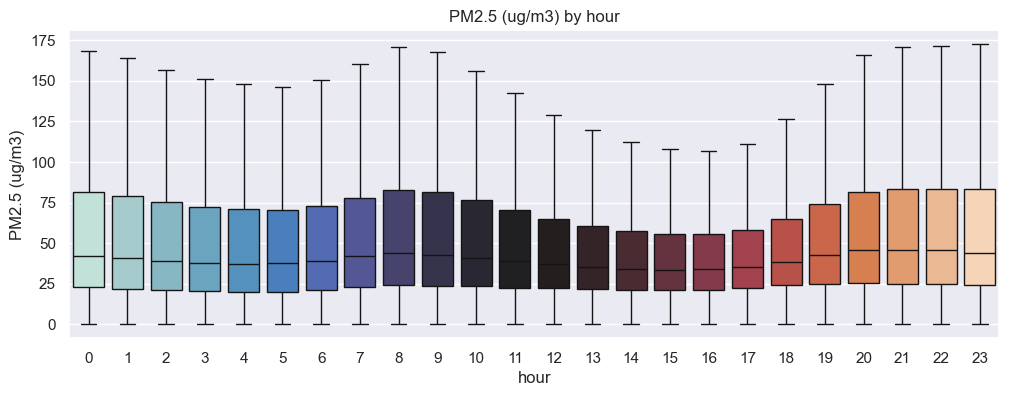

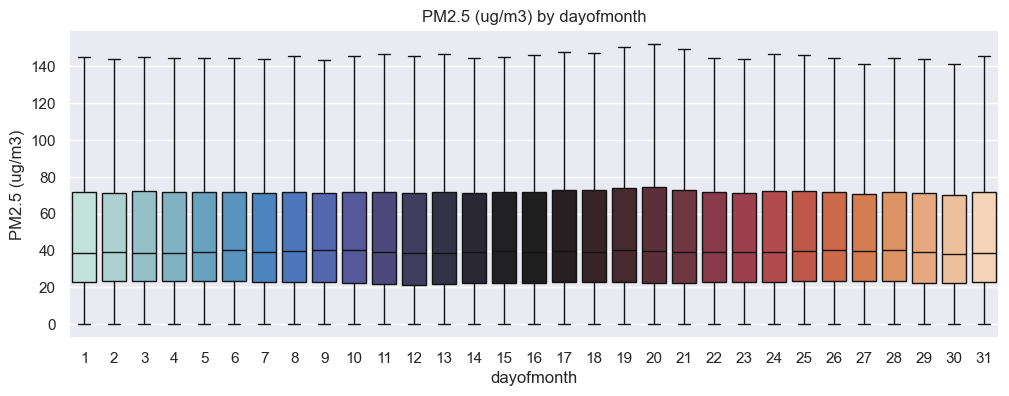

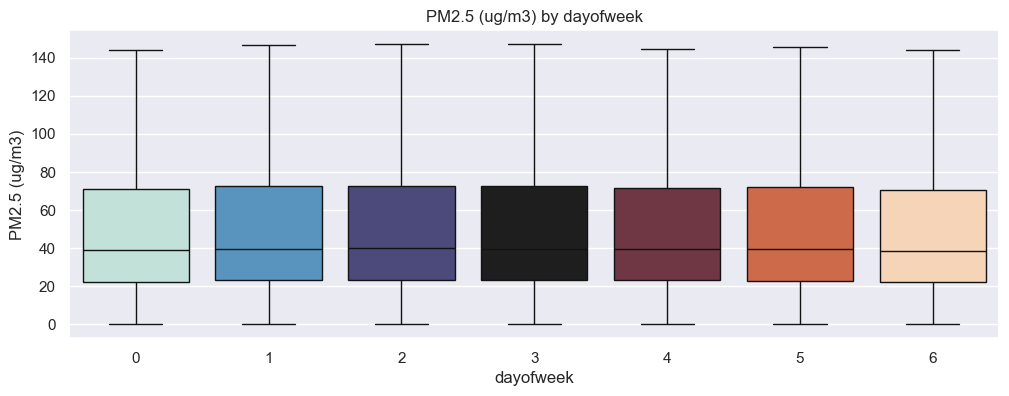

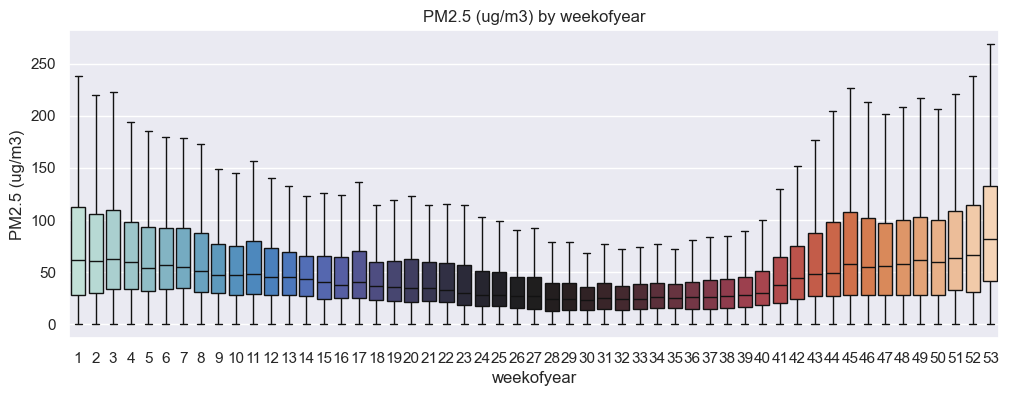

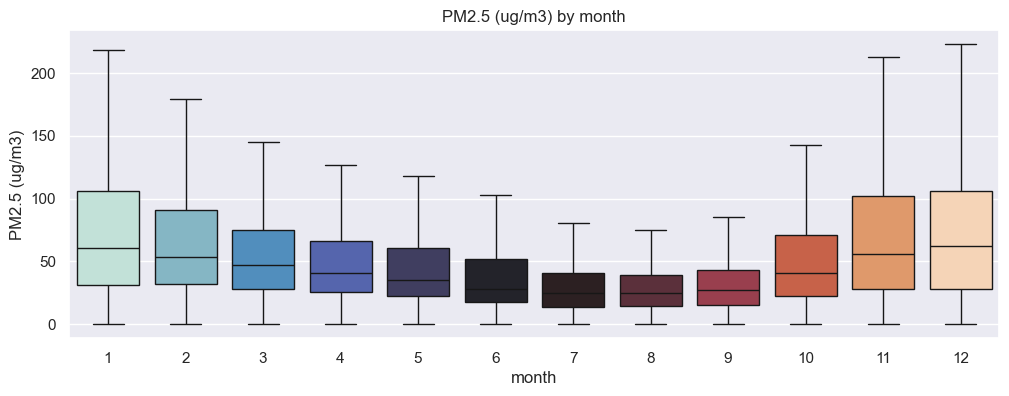

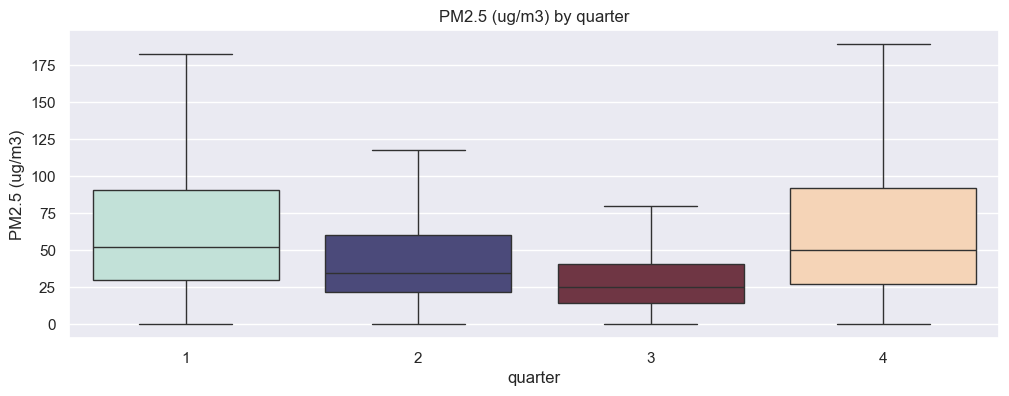

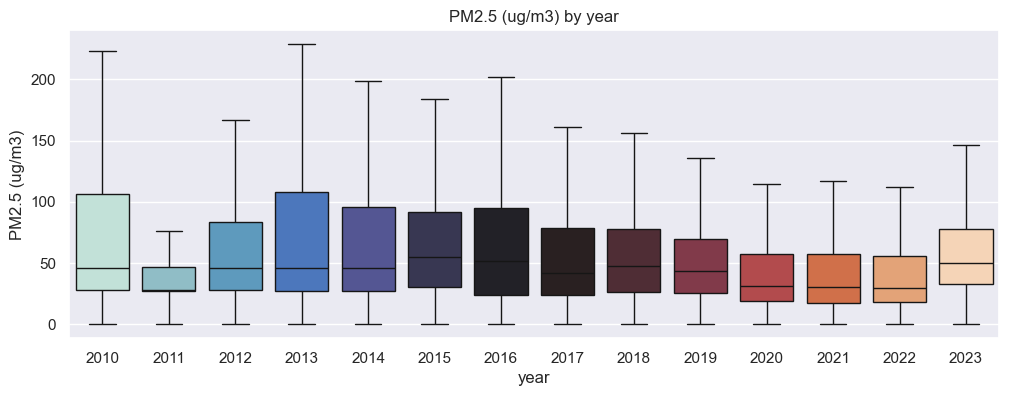

In [44]:
plot_by_datetime('PM2.5 (ug/m3)', ['hour', 'dayofmonth', 'dayofweek', 'weekofyear', 'month', 'quarter', 'year'])

I grafici mostrano chiaramente che i vari gruppi di date catturano tendenze e informazioni significative. Un punto interessante è che il vettore di feature `dayofweek` potrebbe non essere così rilevante, dato che la distribuzione appare simile per tutti i giorni della settimana. Tuttavia, includeremo comunque tutte queste informazioni nel nostro modello.

# Dataset sulla **Qualità dell'Aria in Cina**



Il dataset in questione è stato messo a disposizione dal Beijing Municipal Environmental Monitoring Center, l’ente ufficiale del Governo Cinese deputato al monitoraggio e alla gestione dell’inquinamento atmosferico, al fine di raccogliere informazioni relative alle condizioni della qualità dell’aria nel distretto di Beijing nel periodo compreso tra il 2013 e il 2017.

Sempre citando la documentazione ufficiale, il dataset permette di indagare su numerose variabili ambientali e parametri atmosferici che includono:

- PM10 e PM2.5: concentrazioni di particolato in ug/m³;
- CO: monossido di carbonio (mg/m³);
- NO₂: biossido di azoto (ug/m³);
- SO₂: anidride solforosa (ug/m³);
- O3: concentrazione di Ozono (ug/m^3);
- Parametri meteorologici e ambientali quali temperatura, pressione barometrica, temperatura del punto di rugiada, precipitazioni, velocità e direzione del vento.

Unione dei vari CSV in un unico file

In [45]:
csv_folder = china_extract_to
output_file = os.path.join(china_extract_to, 'combined_dataset.csv')


csv_files = [f for f in os.listdir(csv_folder) if f.endswith('.csv')]
print(f"Found {len(csv_files)} CSV files.")


dfs = []
for file in csv_files:
    path = os.path.join(csv_folder, file)
    try:
        df_china = pd.read_csv(path)
        dfs.append(df_china)
        print(f"Loaded {file} with {len(df_china)} rows.")
    except Exception as e:
        print(f"Error reading {file}: {e}")

if not dfs:
    raise ValueError("No CSV files were successfully loaded.")

combined_df = pd.concat(dfs, ignore_index=True)
print(f"\nCombined DataFrame has {len(combined_df)} rows and {len(combined_df.columns)} columns.")


combined_df.to_csv(output_file, index=False)
print(f"\nCombined CSV saved to: {output_file}")

Found 13 CSV files.
Loaded combined_dataset.csv with 5469984 rows.
Loaded PRSA_Data_Aotizhongxin_20130301-20170228.csv with 35064 rows.
Loaded PRSA_Data_Changping_20130301-20170228.csv with 35064 rows.
Loaded PRSA_Data_Dingling_20130301-20170228.csv with 35064 rows.
Loaded PRSA_Data_Dongsi_20130301-20170228.csv with 35064 rows.
Loaded PRSA_Data_Guanyuan_20130301-20170228.csv with 35064 rows.
Loaded PRSA_Data_Gucheng_20130301-20170228.csv with 35064 rows.
Loaded PRSA_Data_Huairou_20130301-20170228.csv with 35064 rows.
Loaded PRSA_Data_Nongzhanguan_20130301-20170228.csv with 35064 rows.
Loaded PRSA_Data_Shunyi_20130301-20170228.csv with 35064 rows.
Loaded PRSA_Data_Tiantan_20130301-20170228.csv with 35064 rows.
Loaded PRSA_Data_Wanliu_20130301-20170228.csv with 35064 rows.
Loaded PRSA_Data_Wanshouxigong_20130301-20170228.csv with 35064 rows.

Combined DataFrame has 5890752 rows and 18 columns.

Combined CSV saved to: datasets/china\combined_dataset.csv


Si procede alla lettura del file contenente le informazioni relative alle varie stazioni di monitoraggio. Successivamente, verranno rimosse alcune colonne ritenute non necessarie per l'analisi in corso, al fine di semplificare la struttura del dataset ed enfatizzare solo le informazioni rilevanti.

In [46]:
dataframe = pd.read_csv(f'{china_extract_to}/combined_dataset.csv')
dataframe.head()

No  year  month  day  hour  PM2.5  PM10   SO2   NO2     CO    O3  TEMP  \
0   1  2013      3    1     0    4.0   4.0   4.0   7.0  300.0  77.0  -0.7   
1   2  2013      3    1     1    8.0   8.0   4.0   7.0  300.0  77.0  -1.1   
2   3  2013      3    1     2    7.0   7.0   5.0  10.0  300.0  73.0  -1.1   
3   4  2013      3    1     3    6.0   6.0  11.0  11.0  300.0  72.0  -1.4   
4   5  2013      3    1     4    3.0   3.0  12.0  12.0  300.0  72.0  -2.0   

     PRES  DEWP  RAIN   wd  WSPM       station  
0  1023.0 -18.8   0.0  NNW   4.4  Aotizhongxin  
1  1023.2 -18.2   0.0    N   4.7  Aotizhongxin  
2  1023.5 -18.2   0.0  NNW   5.6  Aotizhongxin  
3  1024.5 -19.4   0.0   NW   3.1  Aotizhongxin  
4  1025.2 -19.5   0.0    N   2.0  Aotizhongxin

In [47]:
dataframe.drop(columns=['No'], inplace=True)
dataframe.head()

year  month  day  hour  PM2.5  PM10   SO2   NO2     CO    O3  TEMP    PRES  \
0  2013      3    1     0    4.0   4.0   4.0   7.0  300.0  77.0  -0.7  1023.0   
1  2013      3    1     1    8.0   8.0   4.0   7.0  300.0  77.0  -1.1  1023.2   
2  2013      3    1     2    7.0   7.0   5.0  10.0  300.0  73.0  -1.1  1023.5   
3  2013      3    1     3    6.0   6.0  11.0  11.0  300.0  72.0  -1.4  1024.5   
4  2013      3    1     4    3.0   3.0  12.0  12.0  300.0  72.0  -2.0  1025.2   

   DEWP  RAIN   wd  WSPM       station  
0 -18.8   0.0  NNW   4.4  Aotizhongxin  
1 -18.2   0.0    N   4.7  Aotizhongxin  
2 -18.2   0.0  NNW   5.6  Aotizhongxin  
3 -19.4   0.0   NW   3.1  Aotizhongxin  
4 -19.5   0.0    N   2.0  Aotizhongxin

Si crea una lista di tutti i distretti presenti nel dataset, assicurandosi di includere ciascun nome una sola volta. Questo passaggio fornisce una visione d’insieme delle regioni coperte dai dati, supportando analisi geografiche e suddivisioni successive.

In [48]:
unique_cities = dataframe['station'].unique()
unique_cities

array(['Aotizhongxin', 'Changping', 'Dingling', 'Dongsi', 'Guanyuan',
       'Gucheng', 'Huairou', 'Nongzhanguan', 'Shunyi', 'Tiantan',
       'Wanliu', 'Wanshouxigong'], dtype=object)

Successivamente si crea una vista del numero di entry per ogni distretto. Questo passaggio fornisce una visone dell'uniformità del quantitativo dei dati presenti in ogni distretto.

[12] different cities and [5890752] total records available.


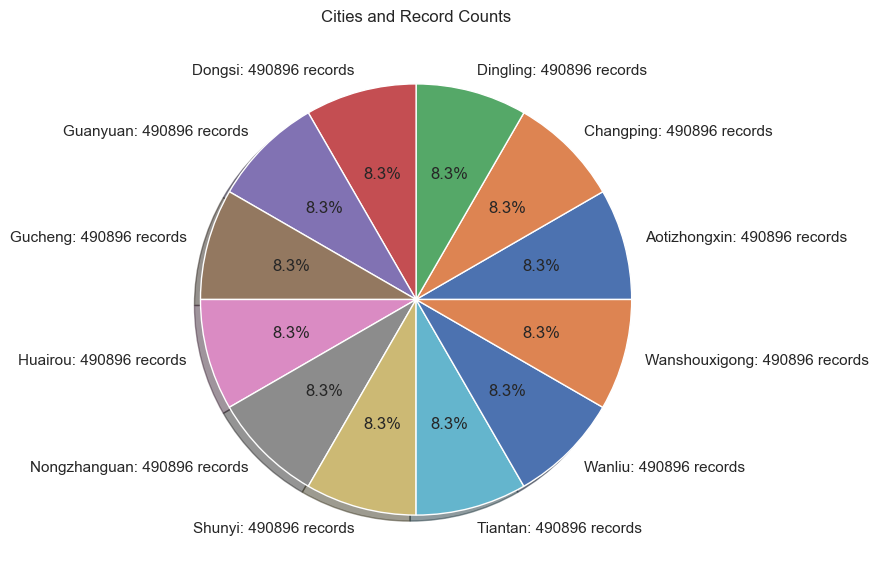

In [49]:
# Quick overview
print(f"[{dataframe['station'].nunique()}] different cities and [{dataframe['station'].count()}] total records available.")

# Get city counts
cities = dataframe["station"].value_counts()

cities.plot.pie(
    labels=[f"{c}: {p} records" for c, p in zip(cities.index, cities.values)],
    autopct="%.1f%%",
    shadow=True,
    figsize=(7,7),
    title="Cities and Record Counts"
);
plt.ylabel('');
plt.show()

Unione delle colonne temporali

In [50]:
dataframe['datetime'] = pd.to_datetime(
    dataframe[['year', 'month', 'day', 'hour']],
    errors='coerce'
)

# (Optional) Drop the original columns if you no longer need them
dataframe.drop(columns=['year', 'month', 'day', 'hour'], inplace=True)

# Preview the result
dataframe.head()

PM2.5  PM10   SO2   NO2     CO    O3  TEMP    PRES  DEWP  RAIN   wd  WSPM  \
0    4.0   4.0   4.0   7.0  300.0  77.0  -0.7  1023.0 -18.8   0.0  NNW   4.4   
1    8.0   8.0   4.0   7.0  300.0  77.0  -1.1  1023.2 -18.2   0.0    N   4.7   
2    7.0   7.0   5.0  10.0  300.0  73.0  -1.1  1023.5 -18.2   0.0  NNW   5.6   
3    6.0   6.0  11.0  11.0  300.0  72.0  -1.4  1024.5 -19.4   0.0   NW   3.1   
4    3.0   3.0  12.0  12.0  300.0  72.0  -2.0  1025.2 -19.5   0.0    N   2.0   

        station            datetime  
0  Aotizhongxin 2013-03-01 00:00:00  
1  Aotizhongxin 2013-03-01 01:00:00  
2  Aotizhongxin 2013-03-01 02:00:00  
3  Aotizhongxin 2013-03-01 03:00:00  
4  Aotizhongxin 2013-03-01 04:00:00

## Pre-elaborazione dei dati

#### Utilizzo di ‘datetime’ come indice temporale

Per gestire efficacemente le serie storiche, viene utilizzata la colonna `datetime` come indice datetime.

In [51]:
dataframe = dataframe.rename(columns={'station': 'state'})
dataframe = dataframe.set_index('datetime')
dataframe.head()

PM2.5  PM10   SO2   NO2     CO    O3  TEMP    PRES  DEWP  \
datetime                                                                        
2013-03-01 00:00:00    4.0   4.0   4.0   7.0  300.0  77.0  -0.7  1023.0 -18.8   
2013-03-01 01:00:00    8.0   8.0   4.0   7.0  300.0  77.0  -1.1  1023.2 -18.2   
2013-03-01 02:00:00    7.0   7.0   5.0  10.0  300.0  73.0  -1.1  1023.5 -18.2   
2013-03-01 03:00:00    6.0   6.0  11.0  11.0  300.0  72.0  -1.4  1024.5 -19.4   
2013-03-01 04:00:00    3.0   3.0  12.0  12.0  300.0  72.0  -2.0  1025.2 -19.5   

                     RAIN   wd  WSPM         state  
datetime                                            
2013-03-01 00:00:00   0.0  NNW   4.4  Aotizhongxin  
2013-03-01 01:00:00   0.0    N   4.7  Aotizhongxin  
2013-03-01 02:00:00   0.0  NNW   5.6  Aotizhongxin  
2013-03-01 03:00:00   0.0   NW   3.1  Aotizhongxin  
2013-03-01 04:00:00   0.0    N   2.0  Aotizhongxin

### Verifica dei valori mancanti

Il primo passo consiste nel quantificare quanti dati mancanti siano presenti per ciascuna delle feature selezionate.

In [52]:
dataframe.isnull().sum().sort_values(ascending=False)


CO       289814
O3       185878
NO2      169624
SO2      126294
PM2.5    122346
PM10      90286
wd        25508
DEWP       5642
TEMP       5572
PRES       5502
RAIN       5460
WSPM       4452
state         0
dtype: int64

In [53]:
df_china=dataframe
df_china = df_china.dropna(how='all')
df_china = df_china.dropna(how='all', axis='columns')


In [54]:
def get_null_info(dataframe):
    null_vals = dataframe.isnull().sum()

    df_null_vals = pd.concat({'Null Count': null_vals,
                              'Percentage of Missing Values (%)': round(null_vals * 100 / len(dataframe), 2)}, axis=1)

    return df_null_vals.sort_values(by=['Null Count'], ascending=False)

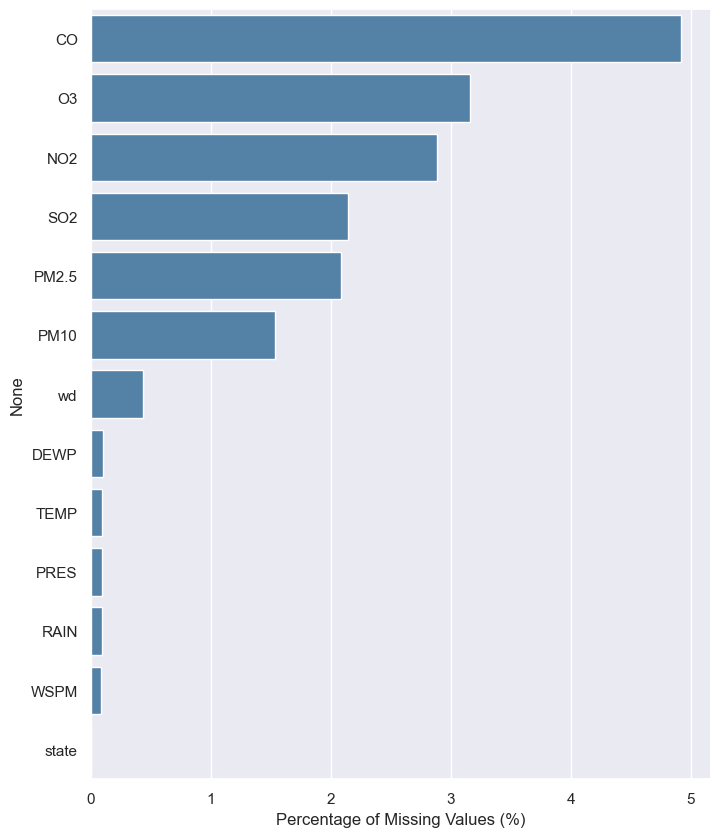

In [55]:
df_null_info = get_null_info(df_china)

plt.figure(figsize=(8, 10))
sns.barplot(data=df_null_info, x='Percentage of Missing Values (%)', y=df_null_info.index, orient='h', color='steelblue')
plt.show()

### Eliminare i valori mancanti per soglia

Non essendoci colonne al di sopra di una certa soglia (>40%) non viene eliminato nulla.

### Analisi esplorativa dei dati

Sto raccogliendo le metriche iniziali in diversi gruppi. Ciò consentirà di effettuare confronti migliori.

In [56]:
pollutants = {
    'Particulate Matter' : ['PM2.5', 'PM10'],
    'Nitrogen Compounds' : ['NO2'],
    'Carbon Monoxide': ['CO'],
    'Sulfur Dioxide': ['SO2'],
    'Ozone Concentration' : ['O3']
}
other_metrics = {
    'Pressure' : ['PRES'],
    'Temperatures' : ['TEMP'],
    'Dew Point Temperature' : ['DEWP'],
    'Rainfall' : ['RAIN'],
    'Wind Direction' : ['wd'],
    'Wind Speed' : ['WSPM']
}

### Frequenze temporali

Cominciamo a raggruppare il nostro DataFrame per varie frequenze temporali.

In [57]:
slice_groups = {
    'Group by Day':   df_china.groupby(pd.Grouper(freq='1D')).mean(numeric_only=True),
    'Group by Month': df_china.groupby(pd.Grouper(freq='1ME')).mean(numeric_only=True),
    'Group by Year':  df_china.groupby(pd.Grouper(freq='1YE')).mean(numeric_only=True)
}

In [58]:
def plot_features_by_group(features, slice_groups):
    for feature in features:
        fig, ax = plt.subplots(1, 1, figsize=(12, 4))
        fig.suptitle(feature)

        labels = []
        for i, (group, group_df) in enumerate(slice_groups.items()):
            data_slice = group_df[group_df.columns.intersection(pollutants[feature])]



            data_slice.plot(kind="line", ax=ax)

            for column in data_slice.columns:
                labels.append(f'{column} [{group}]')

        ax.set(xlabel=None)
        ax.legend(labels)
        plt.plot()

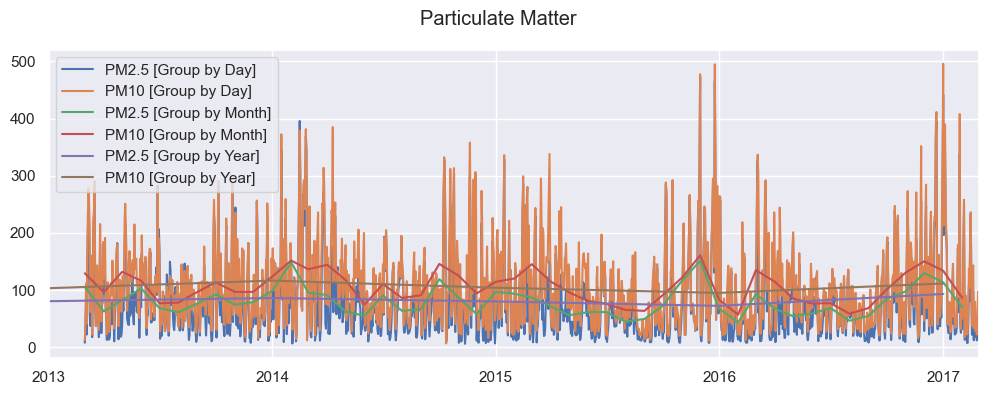

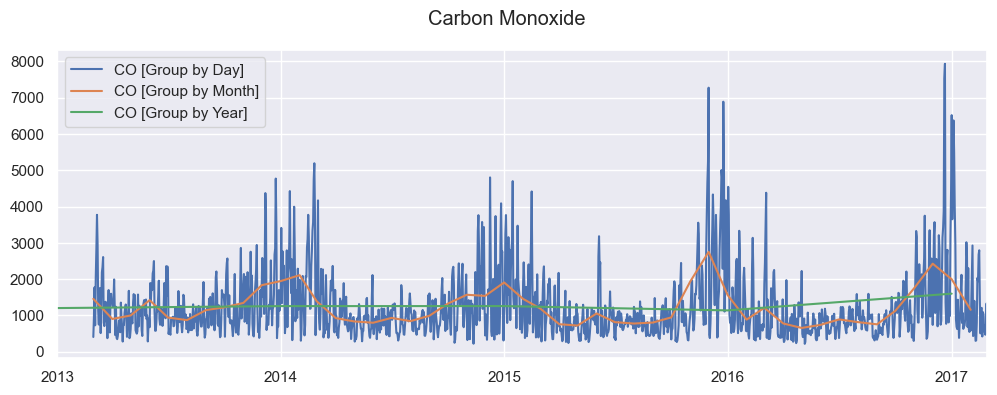

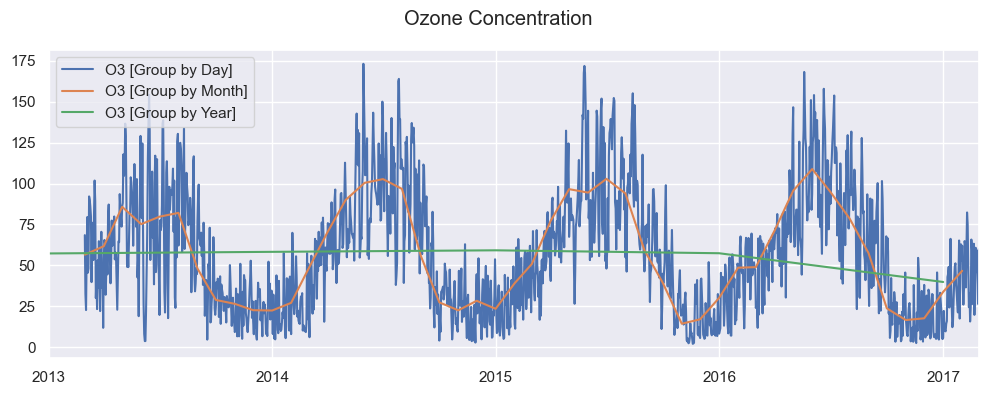

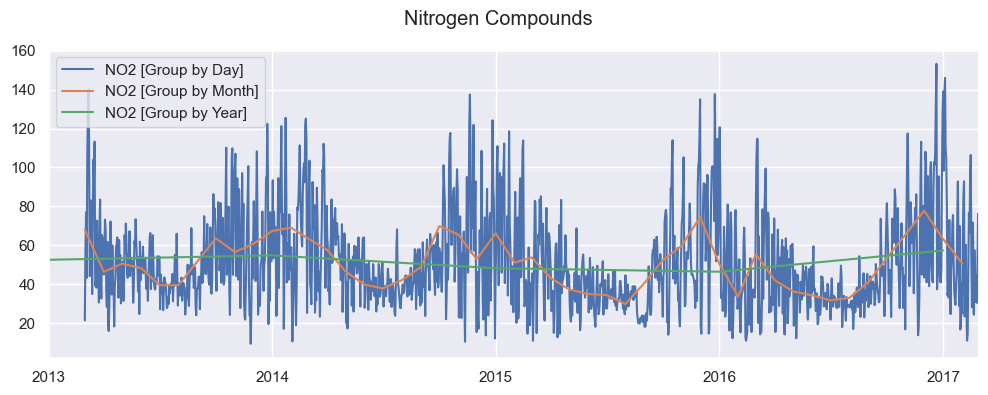

In [59]:
features_to_plot = ['Particulate Matter', 'Carbon Monoxide', 'Ozone Concentration', 'Nitrogen Compounds']
plot_features_by_group(features_to_plot, slice_groups)


### Analisi stagionale su base annua
Dalle metriche selezionate emergono potenziali pattern di tipo stagionale. Per approfondire questa osservazione, eseguiamo un’analisi dettagliata delle variazioni stagionali nell’arco di un anno. Come punto di partenza, prenderemo in considerazione un sottoinsieme di dati relativo al periodo 2016–2017.

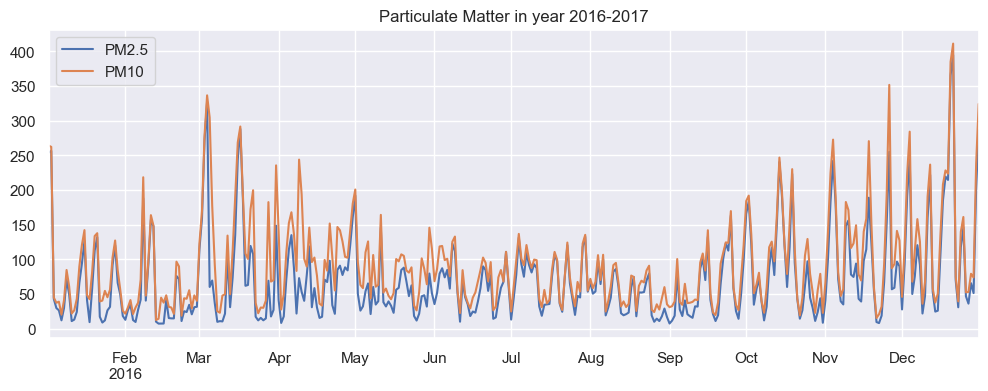

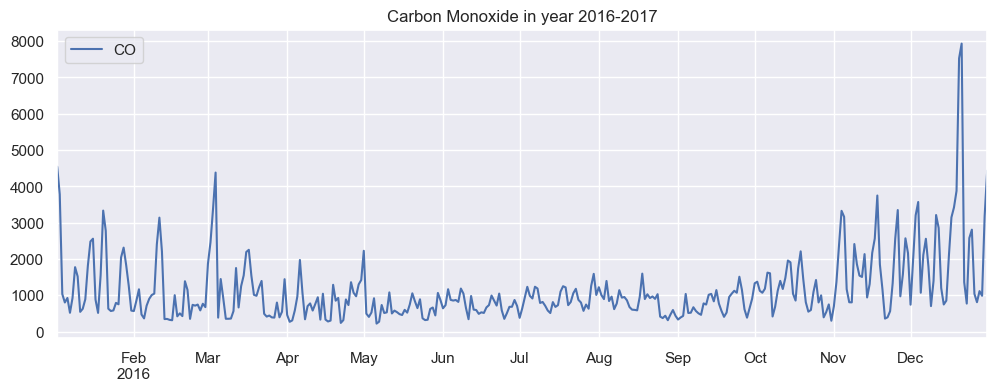

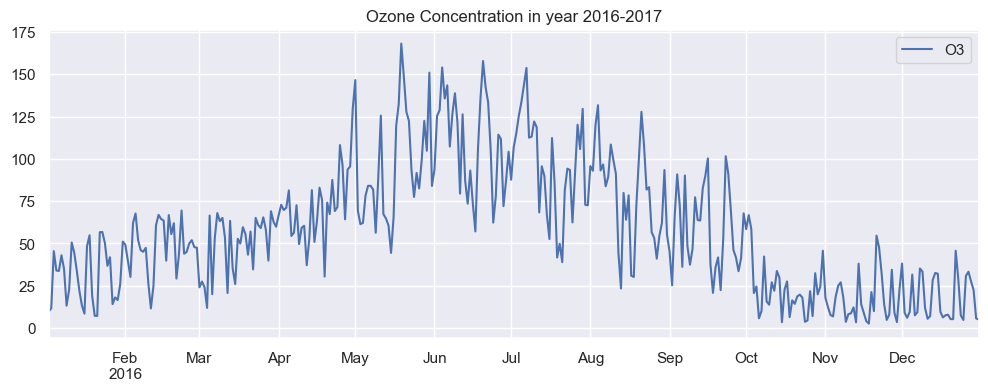

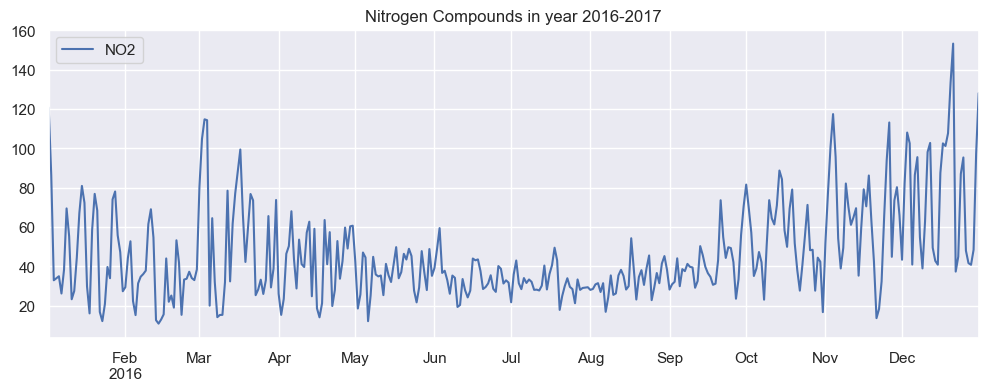

In [60]:
for feature in features_to_plot:
    data_slice = slice_groups['Group by Day'][slice_groups['Group by Day'].columns.intersection(pollutants[feature])]
    data_slice.query('datetime > 2016 and datetime < 2017').plot(title=f'{feature} in year 2016-2017', figsize=(12,4)).set(xlabel=None)

Si osserva un incremento nei valori di `Particulate Matter`, `Nitrogen Compounds` e `Carbon Monoxide` a partire da ottobre, con un picco che tende a persistere fino circa a marzo. Al contrario, la `Ozone Concentration` mostra un comportamento opposto, raggiungendo i valori massimi indicativamente tra maggio e giugno.

### PairPlot
Andiamo ad utilizzare il grafico a coppie, che ci consente di visualizzare in modo più chiaro le relazioni bivariate tra le variabili, nonché la distribuzione univariata di ciascuna di esse.

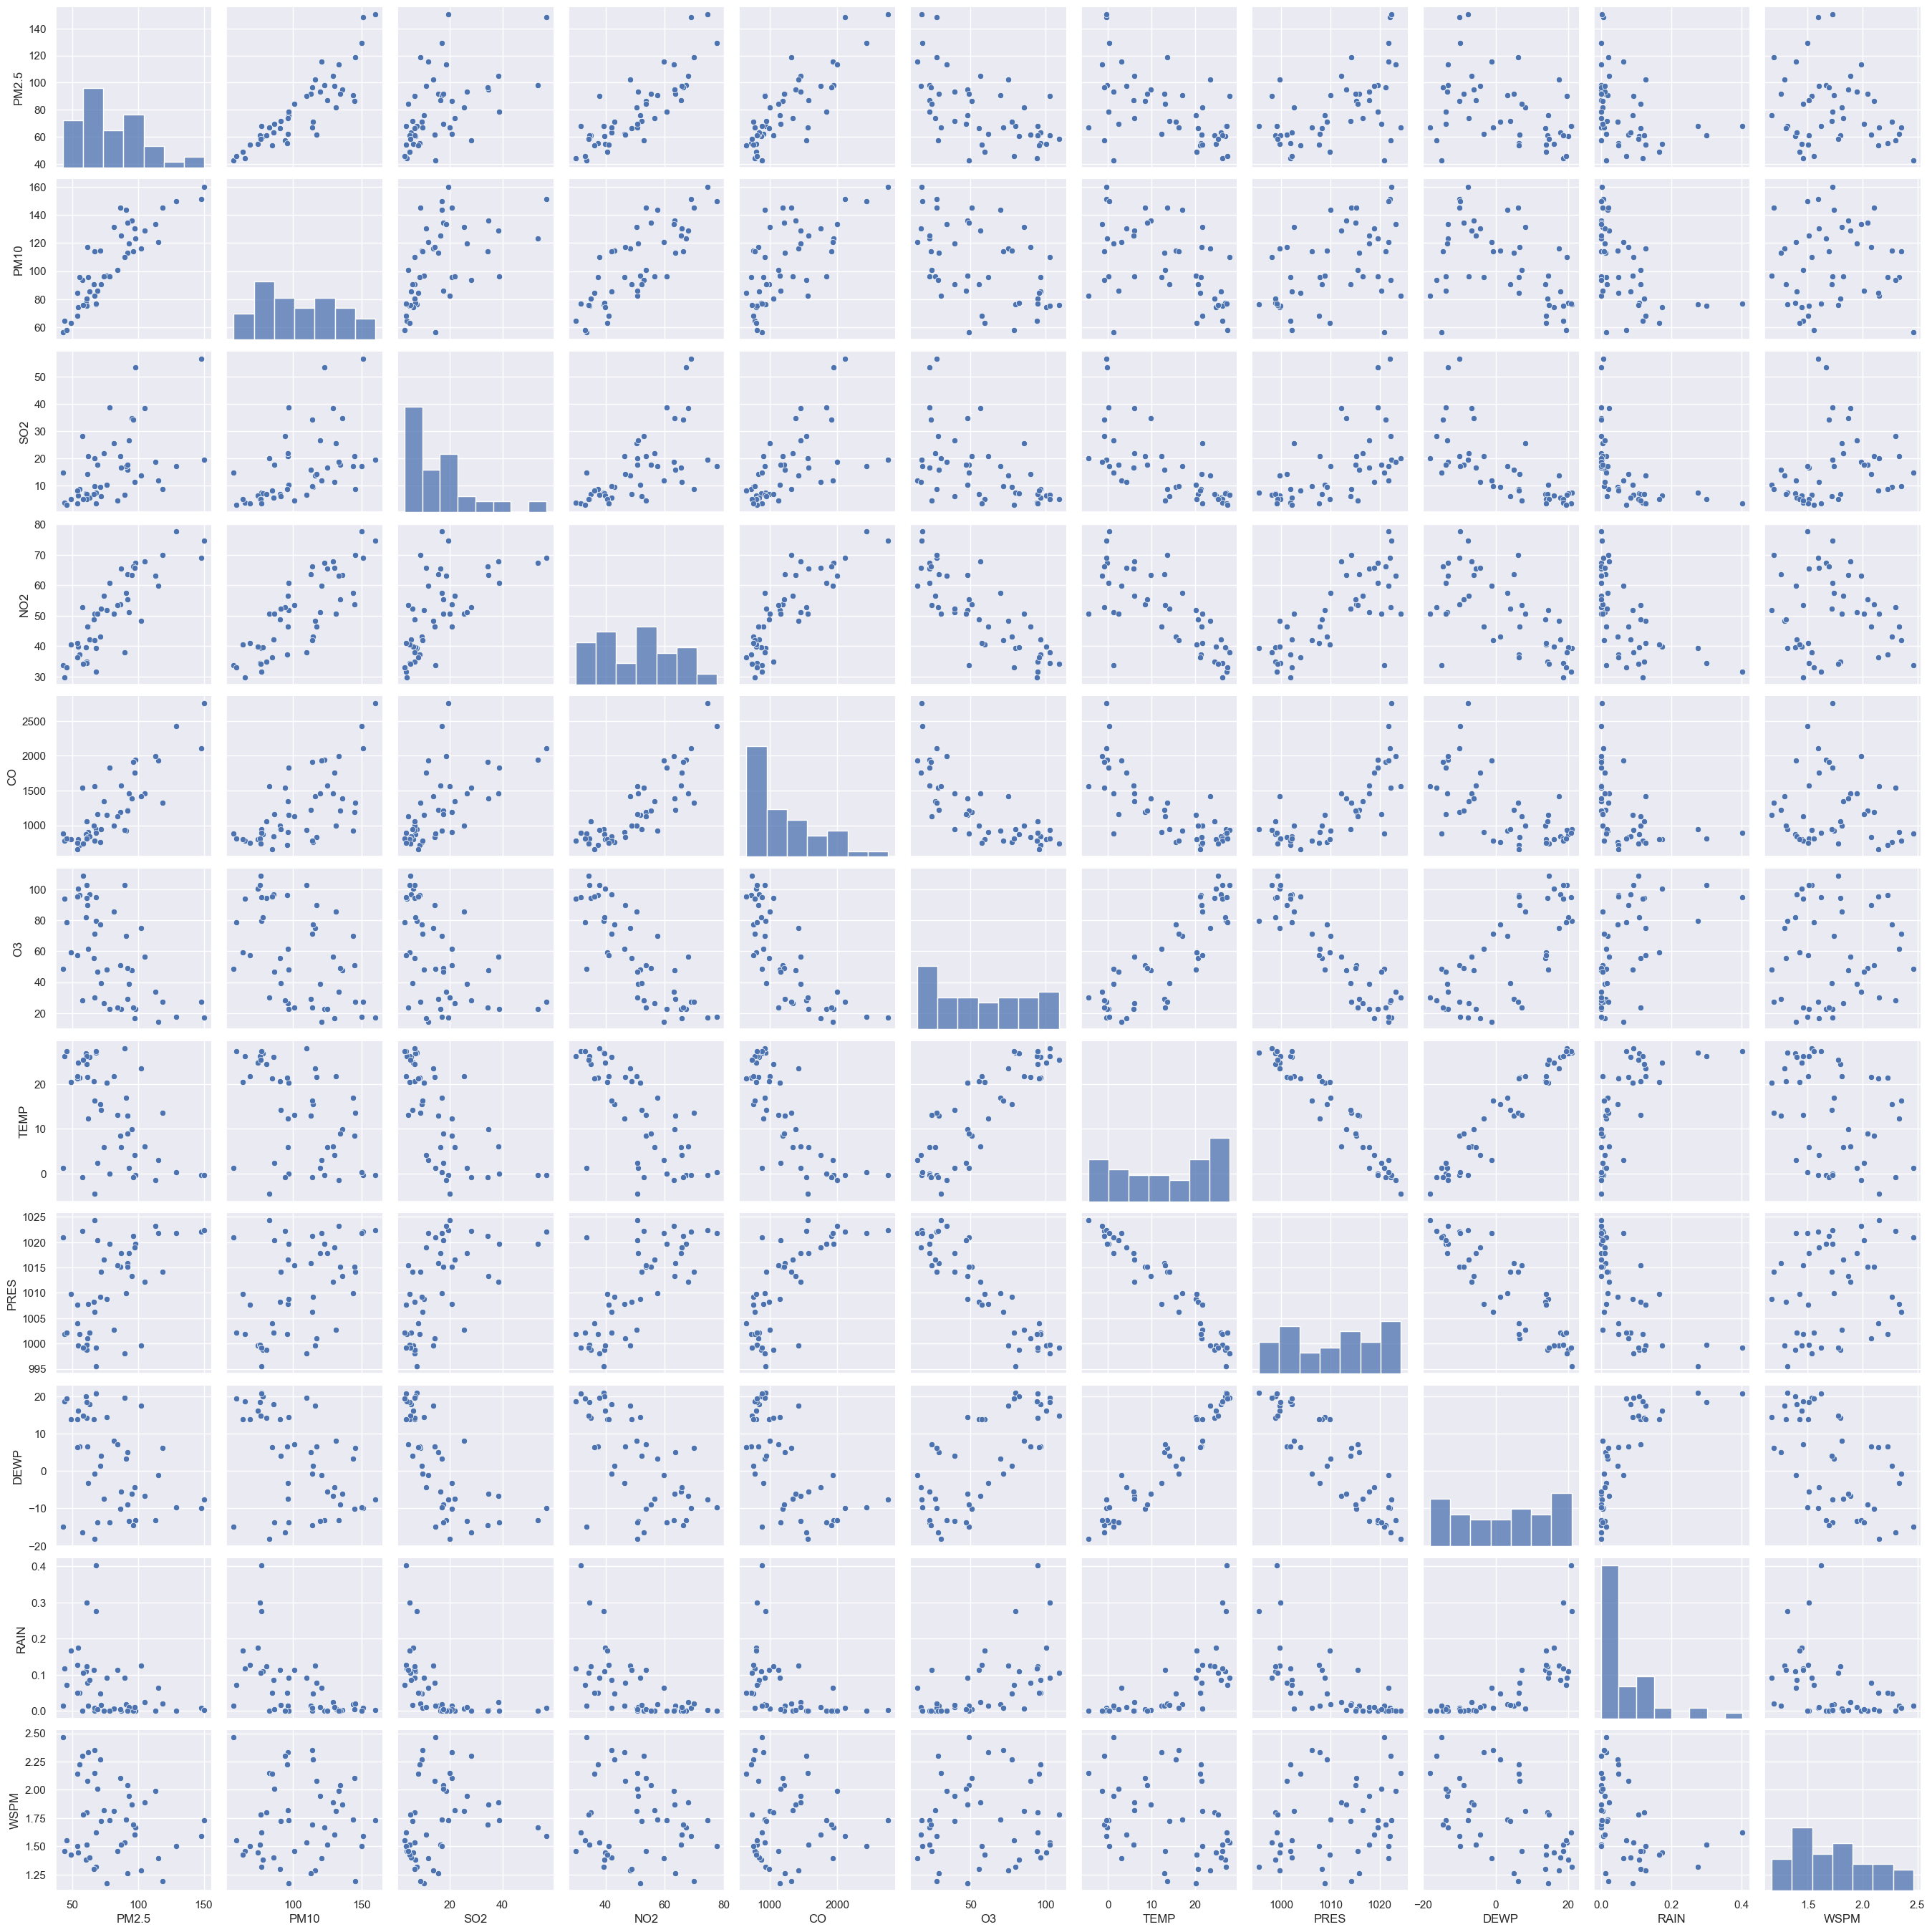

In [61]:
sns.pairplot(slice_groups['Group by Month'])

### Matrice di correlazione
Ora, andiamo ad utilizzare la matrice di correlazione che offre una rappresentazione sintetica ed efficace del grado di associazione lineare tra le diverse variabili del dataset.

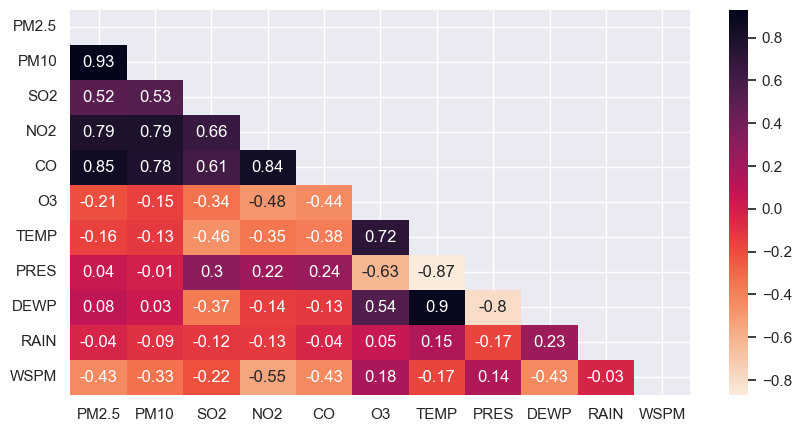

In [62]:
corr = slice_groups['Group by Day'].corr(numeric_only=True).round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10,5))
sns.heatmap(data=corr, mask=mask, annot=True, cmap="rocket_r")
plt.show()

In [63]:
corr_target = abs(corr['PM2.5'])
relevant_features = corr_target[corr_target>0.4]
relevant_features.sort_values(ascending=False)

PM2.5    1.00
PM10     0.93
CO       0.85
NO2      0.79
SO2      0.52
WSPM     0.43
Name: PM2.5, dtype: float64

Il grafico evidenzia diverse correlazioni significative tra le variabili.

Vengono raggruppare le direzioni cardinali del vento mostrando la loro influenza sulla concentrazione di PM2.5

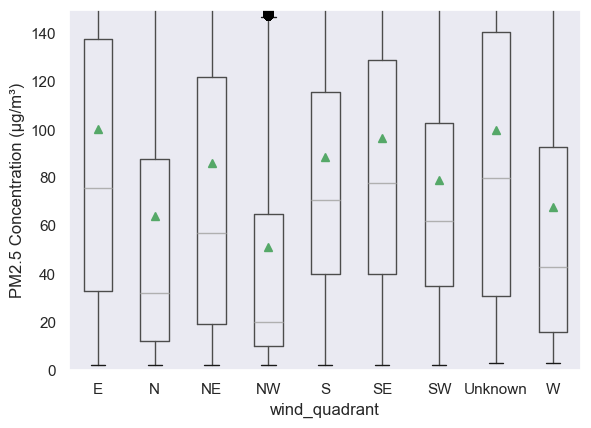

In [64]:
# Apply to the dataframe
def wind_quadrant_str(direction):
    if pd.isna(direction):
        return "Unknown"
    direction = direction.upper()

    if direction in ['N', 'NNE', 'NNW']:
        return "N"
    elif direction in ['NE']:
        return "NE"
    elif direction in ['E', 'ENE', 'ESE']:
        return "E"
    elif direction in ['NW']:
        return "NW"
    elif direction in ['S', 'SSE', 'SSW']:
        return "S"
    elif direction in ['SE']:
        return "SE"
    elif direction in ['W', 'WNW', 'WSW']:
        return "W"
    elif direction in ['SW']:
        return "SW"
    else:
        return "Other"

# Apply to the dataframe
dataframe["wind_quadrant"] = dataframe["wd"].apply(wind_quadrant_str)

# Boxplot
ax = dataframe.boxplot(
    column="PM2.5",
    by="wind_quadrant",
    showmeans=True,
    grid=False
)
ax.set_ylabel("PM2.5 Concentration (µg/m³)")
ax.set_title("")
plt.suptitle("")
plt.ylim(0, 150)
plt.show()


### Resampling
Poiché il dataframe combinato include misurazioni provenienti da diverse località all'interno dello stesso stato e riferite agli stessi intervalli temporali, è possibile che si verifichino duplicazioni temporali. Dal momento che l’obiettivo è analizzare la qualità dell’aria a livello statale, procederemo con un ricampionamento temporale aggregando i dati mediante media delle misurazioni corrispondenti allo stesso timestamp.

In [65]:
df_resampled = (
    df_china
    .groupby('state')  # Resample within each state
    .resample('60min')
    .mean(numeric_only=True)
    .reset_index()
)
df_resampled = df_resampled.set_index('datetime')
df_china=df_resampled.copy()

### Isolation Forest - Rilevamento e Rimozione degli Outlier
Utilizzeremo l'algoritmo Isolation Forest per identificare e rimuovere automaticamente gli outlier dalle nostre quattro variabili ambientali.

Definiamo le colonne su cui applicheremo Isolation Forest: `PM2.5`, `CO`, `O3` e `NO2`.

In [66]:
features = ['PM2.5', 'CO', 'O3', 'NO2']
df_china_features = df_china[features].copy()

Impostiamo il parametro `contamination` in base alla percentuale di outlier attesa (qui 1%).

In [67]:
iso = IsolationForest(contamination=0.01, random_state=42)
iso.fit(df_china_features)

IsolationForest(contamination=0.01, random_state=42)

Con `predict`, i valori anomali vengono etichettati con -1, quelli normali con +1.

In [68]:
df_china['anomaly'] = iso.predict(df_china_features)

Creiamo un nuovo DataFrame `df_clean` escludendo tutte le righe etichettate come outlier.

In [69]:
df_china_clean = df_china[df_china['anomaly'] == 1].drop(columns='anomaly')

Confrontiamo le distribuzioni originali e quelle ripulite per ciascuna variabile.

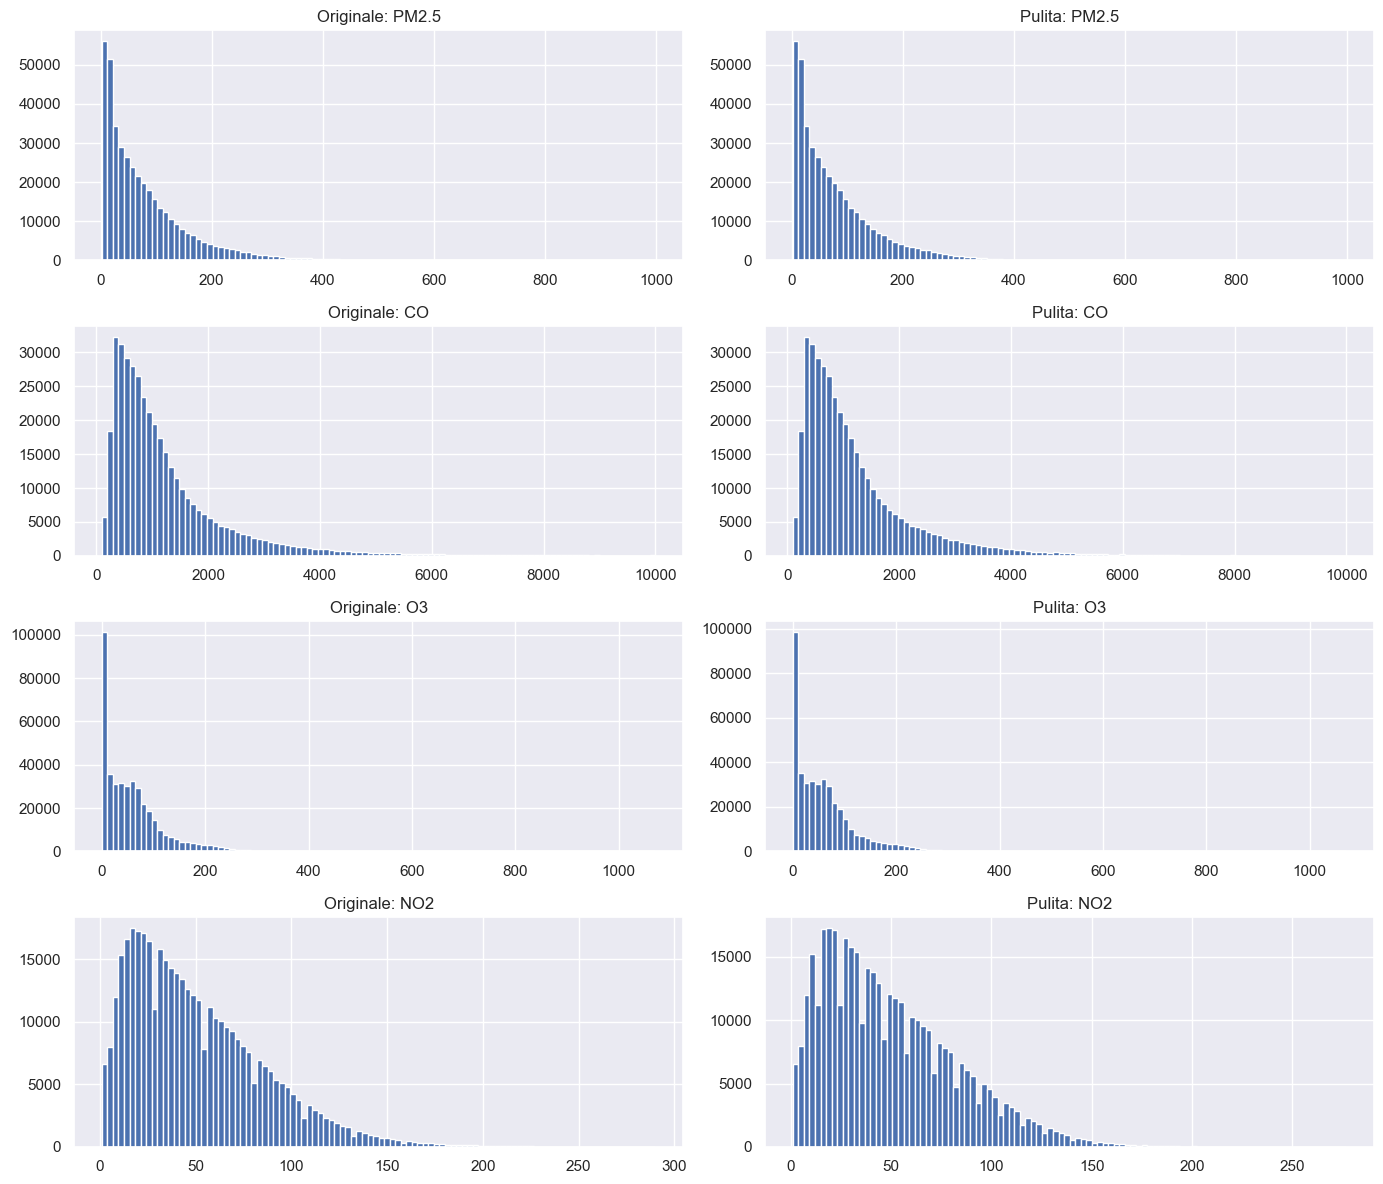

state  PM2.5  PM10   SO2   NO2     CO    O3  TEMP  \
datetime                                                                        
2013-03-01 00:00:00  Aotizhongxin    4.0   4.0   4.0   7.0  300.0  77.0  -0.7   
2013-03-01 01:00:00  Aotizhongxin    8.0   8.0   4.0   7.0  300.0  77.0  -1.1   
2013-03-01 02:00:00  Aotizhongxin    7.0   7.0   5.0  10.0  300.0  73.0  -1.1   
2013-03-01 03:00:00  Aotizhongxin    6.0   6.0  11.0  11.0  300.0  72.0  -1.4   
2013-03-01 04:00:00  Aotizhongxin    3.0   3.0  12.0  12.0  300.0  72.0  -2.0   

                       PRES  DEWP  RAIN  WSPM  
datetime                                       
2013-03-01 00:00:00  1023.0 -18.8   0.0   4.4  
2013-03-01 01:00:00  1023.2 -18.2   0.0   4.7  
2013-03-01 02:00:00  1023.5 -18.2   0.0   5.6  
2013-03-01 03:00:00  1024.5 -19.4   0.0   3.1  
2013-03-01 04:00:00  1025.2 -19.5   0.0   2.0

In [70]:
fig, axes = plt.subplots(4, 2, figsize=(14, 12))
for i, col in enumerate(features):
    # istogramma dati originali
    axes[i, 0].hist(df_china[col].dropna(), bins=100)
    axes[i, 0].set_title(f"Originale: {col}")
    # istogramma dati puliti
    axes[i, 1].hist(df_china_clean[col].dropna(), bins=100)
    axes[i, 1].set_title(f"Pulita: {col}")
plt.tight_layout()
plt.show()

df_china = df_china_clean.copy()
df_china.head()

### Gestione dei valori mancanti

In [71]:
get_null_info(df_china)
df_china.head()

state  PM2.5  PM10   SO2   NO2     CO    O3  TEMP  \
datetime                                                                        
2013-03-01 00:00:00  Aotizhongxin    4.0   4.0   4.0   7.0  300.0  77.0  -0.7   
2013-03-01 01:00:00  Aotizhongxin    8.0   8.0   4.0   7.0  300.0  77.0  -1.1   
2013-03-01 02:00:00  Aotizhongxin    7.0   7.0   5.0  10.0  300.0  73.0  -1.1   
2013-03-01 03:00:00  Aotizhongxin    6.0   6.0  11.0  11.0  300.0  72.0  -1.4   
2013-03-01 04:00:00  Aotizhongxin    3.0   3.0  12.0  12.0  300.0  72.0  -2.0   

                       PRES  DEWP  RAIN  WSPM  
datetime                                       
2013-03-01 00:00:00  1023.0 -18.8   0.0   4.4  
2013-03-01 01:00:00  1023.2 -18.2   0.0   4.7  
2013-03-01 02:00:00  1023.5 -18.2   0.0   5.6  
2013-03-01 03:00:00  1024.5 -19.4   0.0   3.1  
2013-03-01 04:00:00  1025.2 -19.5   0.0   2.0

In [72]:
numeric_cols = df_china.select_dtypes(include='number').columns

df_china[numeric_cols] = df_china[numeric_cols].interpolate(method='pad')
df_china[numeric_cols] = df_china[numeric_cols].fillna(df_china[numeric_cols].mean())

df_china.info()

C:\Users\jacop\AppData\Local\Temp\ipykernel_11308\594917411.py:3: FutureWarning: DataFrame.interpolate with method=pad is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_china[numeric_cols] = df_china[numeric_cols].interpolate(method='pad')


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 416560 entries, 2013-03-01 00:00:00 to 2017-02-28 23:00:00
Data columns (total 12 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   state   416560 non-null  object 
 1   PM2.5   416560 non-null  float64
 2   PM10    416560 non-null  float64
 3   SO2     416560 non-null  float64
 4   NO2     416560 non-null  float64
 5   CO      416560 non-null  float64
 6   O3      416560 non-null  float64
 7   TEMP    416560 non-null  float64
 8   PRES    416560 non-null  float64
 9   DEWP    416560 non-null  float64
 10  RAIN    416560 non-null  float64
 11  WSPM    416560 non-null  float64
dtypes: float64(11), object(1)
memory usage: 41.3+ MB


### Arricchimento del Dataset con Caratteristiche Aggiuntive
Procediamo con l'ampliamento del nostro dataset, integrando nuove features che possano risultare utili.

In [73]:
def create_features(df):
    df = df.copy()
    df['hour']       = df.index.hour
    df['dayofmonth'] = df.index.day
    df['dayofweek']  = df.index.dayofweek
    df['dayofyear']  = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week.astype("int64")
    df['month']      = df.index.month
    df['quarter']    = df.index.quarter
    df['year']       = df.index.year
    return df

In [74]:
date_features = ['hour', 'dayofmonth', 'dayofweek', 'dayofyear', 'weekofyear', 'month', 'quarter', 'year']
df_china = create_features(df_china)

Ora, grazie alle features precedentemente descritte, è semplice visualizzare le diverse metriche. Ad esempio, possiamo esaminare la qualità dell'aria nel corso dei mesi utilizzando un boxplot.

In [75]:
def plot_by_datetime(metric, time_groups):
    for time_group in time_groups:
        fig, ax = plt.subplots(figsize=(12, 4))
        sns.boxplot(data=df_china, x=time_group, y=metric, hue=time_group, palette="icefire", showfliers=False, legend=False)
        ax.set_title(f'{metric} by {time_group}')
        ax.set(xlabel=time_group)
        plt.show()

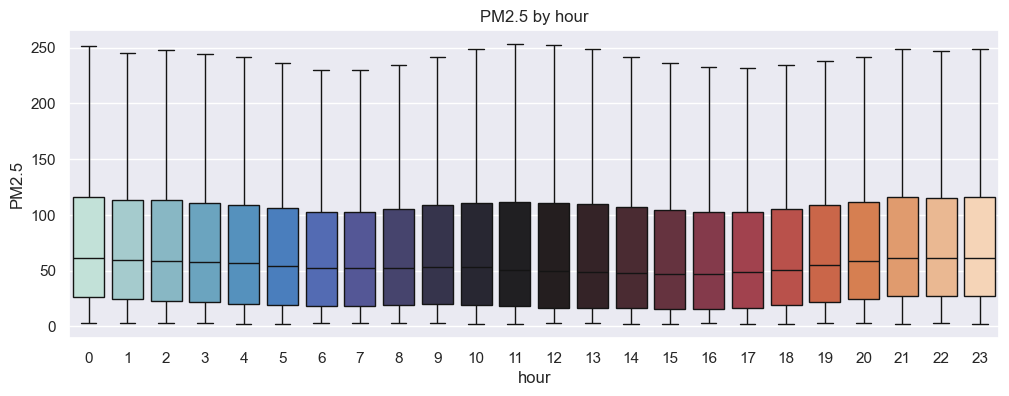

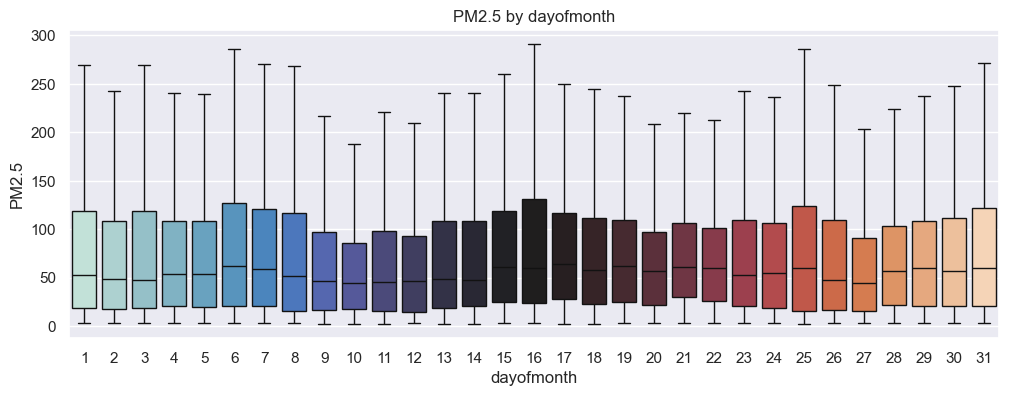

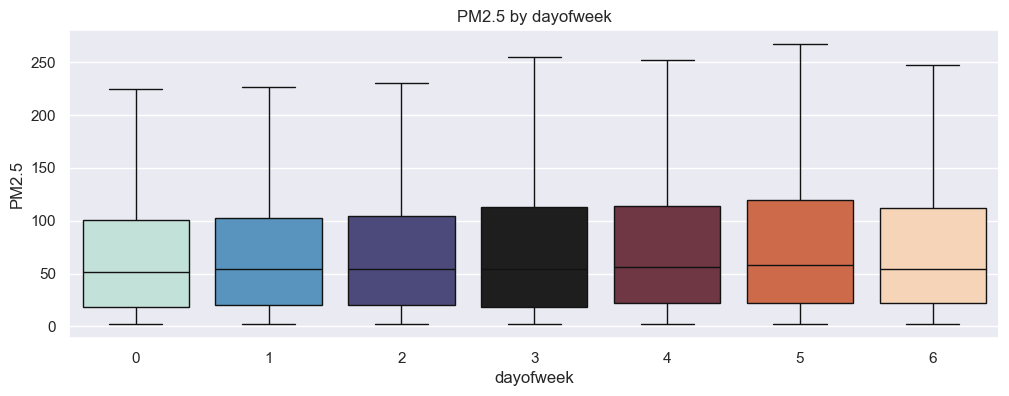

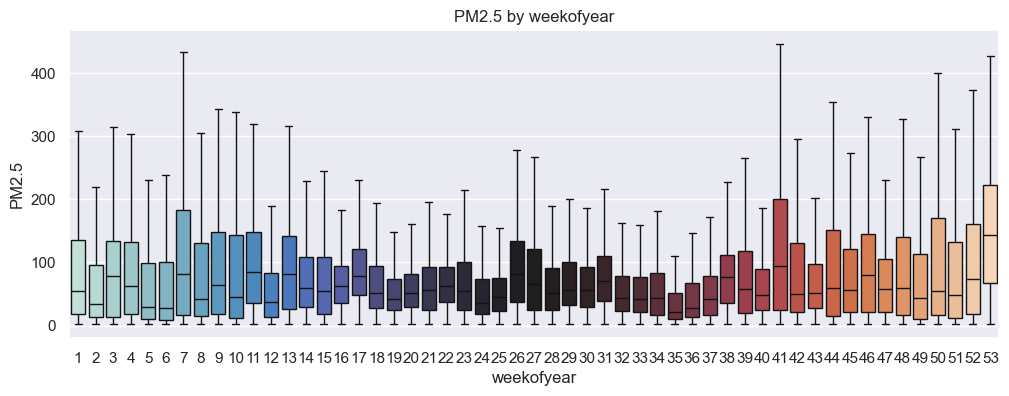

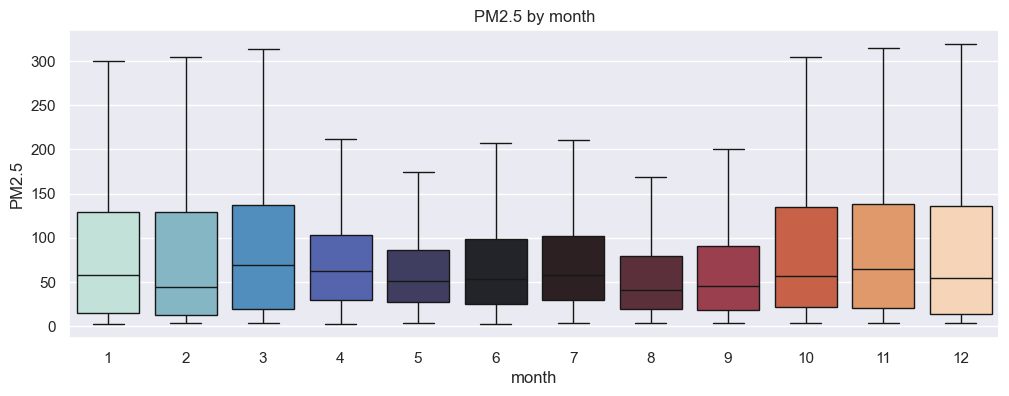

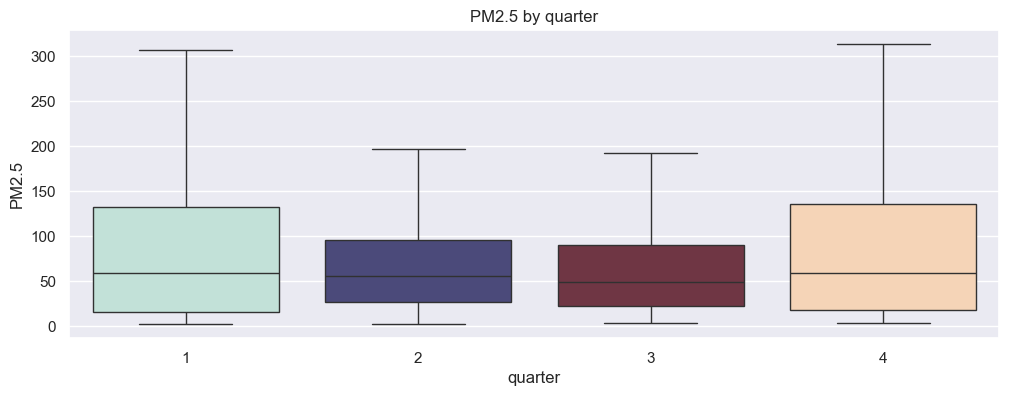

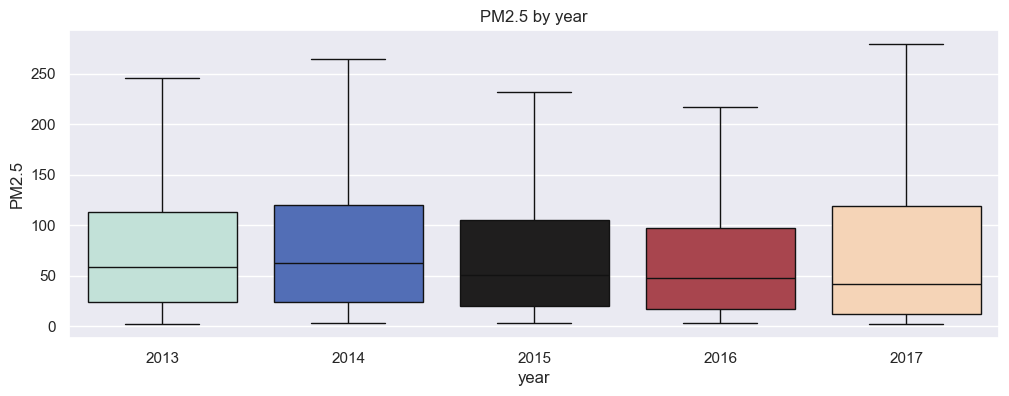

state  PM2.5  PM10   SO2   NO2     CO    O3  TEMP  \
datetime                                                                        
2013-03-01 00:00:00  Aotizhongxin    4.0   4.0   4.0   7.0  300.0  77.0  -0.7   
2013-03-01 01:00:00  Aotizhongxin    8.0   8.0   4.0   7.0  300.0  77.0  -1.1   
2013-03-01 02:00:00  Aotizhongxin    7.0   7.0   5.0  10.0  300.0  73.0  -1.1   
2013-03-01 03:00:00  Aotizhongxin    6.0   6.0  11.0  11.0  300.0  72.0  -1.4   
2013-03-01 04:00:00  Aotizhongxin    3.0   3.0  12.0  12.0  300.0  72.0  -2.0   

                       PRES  DEWP  RAIN  WSPM  hour  dayofmonth  dayofweek  \
datetime                                                                     
2013-03-01 00:00:00  1023.0 -18.8   0.0   4.4     0           1          4   
2013-03-01 01:00:00  1023.2 -18.2   0.0   4.7     1           1          4   
2013-03-01 02:00:00  1023.5 -18.2   0.0   5.6     2           1          4   
2013-03-01 03:00:00  1024.5 -19.4   0.0   3.1     3           1          4   
2013-03-01 04:00:00  1025.2 -19.5   0.0   2.0     4           1          4   

                     dayofyear  weekofyear  month  quarter  year  
datetime                                                          
2013-03-01 00:00:00         60           9      3        1  2013  
2013-03-01 01:00:00         60           9      3        1  2013  
2013-03-01 02:00:00         60           9      3        1  2013  
2013-03-01 03:00:00         60           9      3        1  2013  
2013-03-01 04:00:00         60           9      3        1  2013

In [76]:
plot_by_datetime('PM2.5', ['hour', 'dayofmonth', 'dayofweek', 'weekofyear', 'month', 'quarter', 'year'])
df_china.head()

I grafici mostrano chiaramente che i vari gruppi di date catturano tendenze e informazioni significative. Un punto interessante è che il vettore di feature `dayofweek` potrebbe non essere così rilevante, dato che la distribuzione appare simile per tutti i giorni della settimana. Tuttavia, includeremo comunque tutte queste informazioni nel nostro modello.

# AUGMENTED AI DATA

Il dataset in questione è stato generato da diversi LLM, tra cui: Deepseek (500 entries), Gemini (3900 entries), Claude (300 entries), Qwen (500 entries), Mistral (500 entries), Meta (400 entries), Grock (100 entries), ChatGpt (200 entries), Hunyuan (350 entries), Tencent (400 entries).
Il numero totali di entries utilizzate è proporzionale alla capacità del modello (versione gratuita/prova)  di generare grandi quantitativi di dati.
Il dataset è stato generato prendendo come base i dati dell'unione dei dataset precedenti e performando data augmentation con i modelli menzionati in precedenza.
Il datasef fa riferimento all'anno 2021 e mantiene le stesse variabili ambientali e parametri atmosferici dei precedenti dataset, rendendolo già omogeneo.
I quali includono:

- PM10 e PM2.5: concentrazioni di particolato in ug/m³;
- CO e CO₂: rispettivamente monossido e anidride carbonica, misurati in vari formati (mg/m³, ppm, ecc.);
- NO, NO₂ e NOx: varianti degli ossidi di azoto, riportati in unità adatte (ug/m³, ppb, ppm);
- SO₂, NH₃ e altri inquinanti quali Benzene, CH₄, e composti organici come MP-Xylene, Eth-Benzene, O Xylene, e Xylene;
- Parametri meteorologici e ambientali quali temperatura, pressione barometrica, umidità relativa, velocità e direzione del vento, radiazione solare e precipitazioni.


Caricamento del dataset 

In [77]:
csv_folder = "datasets/"
df_augmented = pd.read_csv(f'{csv_folder}/Augmented_data.csv')
df_augmented.head()

year  month  dayofmonth           state    PM2.5     CO      O3  dayofweek  \
0  2021      1           1  Andhra Pradesh   47.382  0.822  46.518          4   
1  2021      1           1           Assam  127.842  1.383  18.175          4   
2  2021      1           1           Bihar  168.030  2.160  22.843          4   
3  2021      1           1      Chandigarh   47.469  0.811  10.740          4   
4  2021      1           1           Delhi  207.747  2.050  20.065          4   

   quarter  weekofyear  dayofyear  
0        1           1          1  
1        1           1          1  
2        1           1          1  
3        1           1          1  
4        1           1          1

Verifico che gli stati generati appaiano una sola volta all'interno del dataset

In [78]:
valid_states = df_augmented['state'].unique()
valid_states

array(['Andhra Pradesh', 'Assam', 'Bihar', 'Chandigarh', 'Delhi',
       'Gujarat', 'Haryana', 'Jharkhand', 'Karnataka', 'Kerala',
       'Madhya Pradesh', 'Maharashtra', 'Meghalaya', 'Odisha', 'Punjab',
       'Rajasthan', 'Tamil Nadu', 'Telangana', 'Uttar Pradesh',
       'West Bengal', 'Mizoram', 'Nagaland', 'Tripura'], dtype=object)

Verifico il numero di entries per stato

[23] different cities and [6935] total records available.


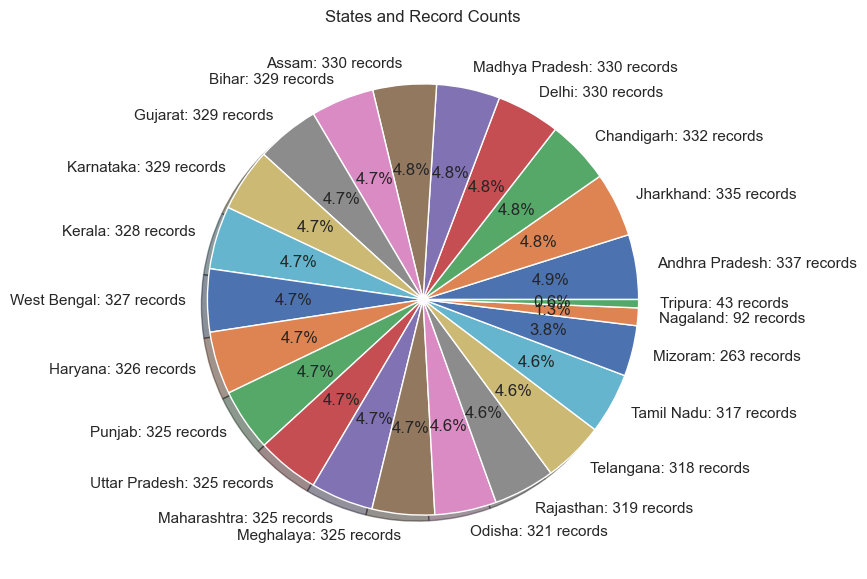

In [79]:
# Quick overview
print(f"[{df_augmented['state'].nunique()}] different cities and [{df_augmented['state'].count()}] total records available.")

# Get city counts
cities = df_augmented["state"].value_counts()

cities.plot.pie(
    labels=[f"{c}: {p} records" for c, p in zip(cities.index, cities.values)],
    autopct="%.1f%%",
    shadow=True,
    figsize=(7,7),
    title="States and Record Counts"
);
plt.ylabel('');
plt.show()

Si nota che i modelli, durante la loro generazione, hanno generato meno stati rispetto ai 32 del dataset omogeneizzato
Il quantitativo dei valori generati ammonta a circa 6900 entries.

In [80]:
def plot_by_datetime(metric, time_groups):
    for time_group in time_groups:
        fig, ax = plt.subplots(figsize=(12, 4))
        sns.boxplot(data=df_augmented, x=time_group, y=metric, hue=time_group, palette="icefire", showfliers=False, legend=False)
        ax.set_title(f'{metric} by {time_group}')
        ax.set(xlabel=time_group)
        plt.show()

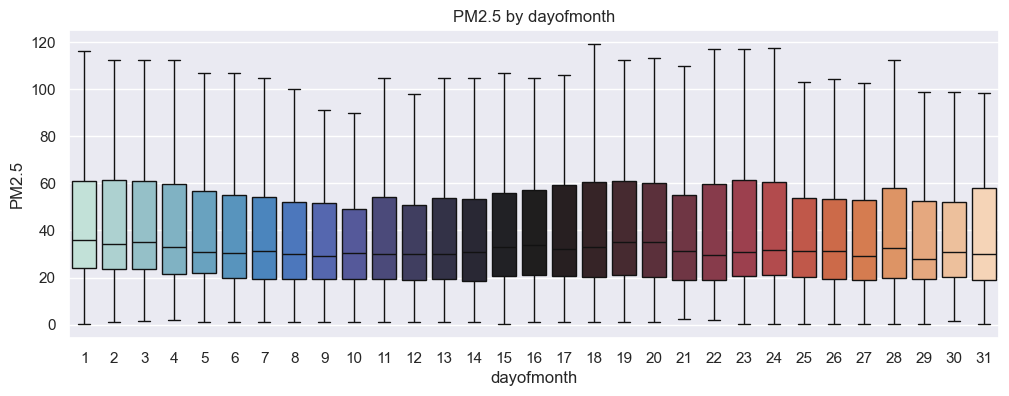

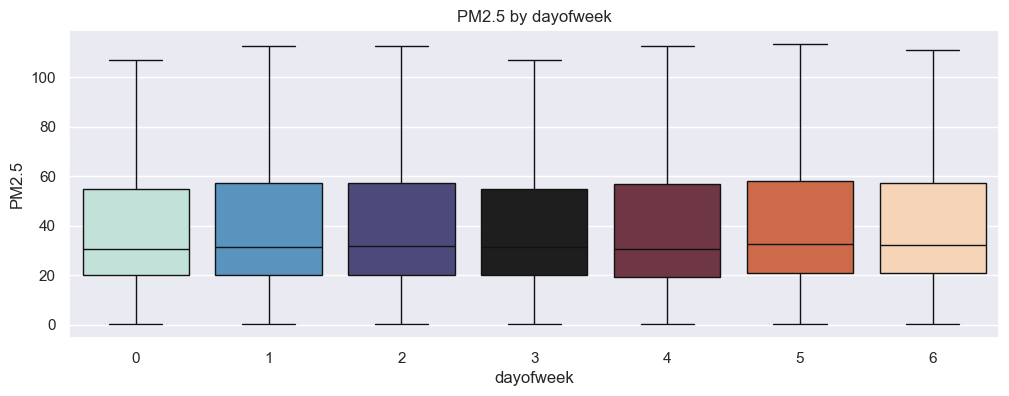

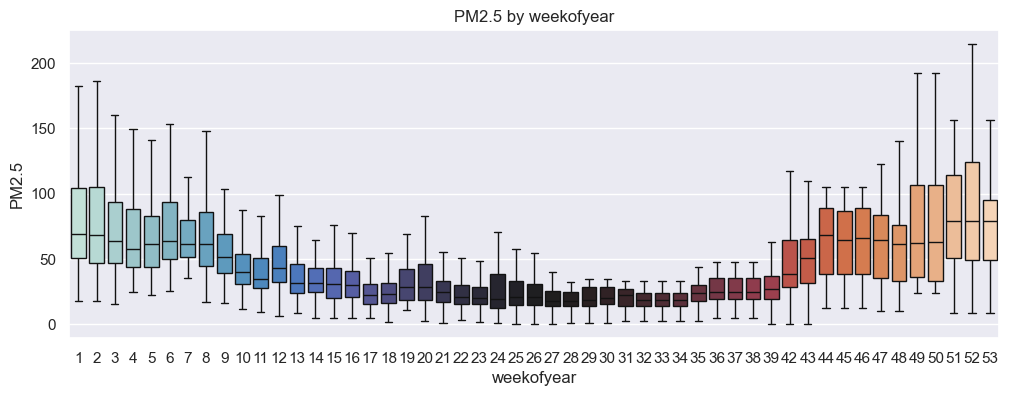

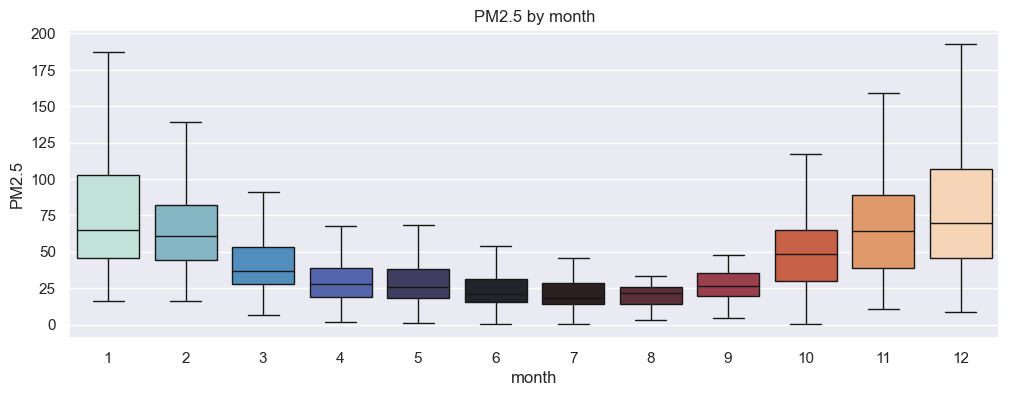

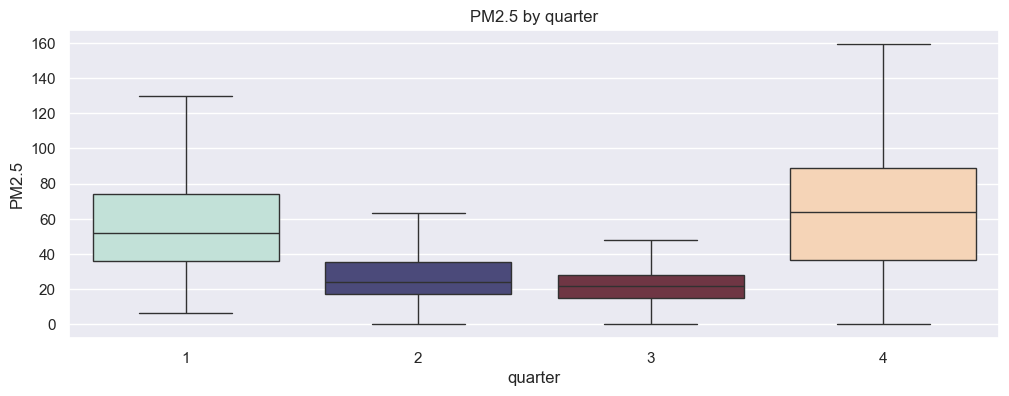

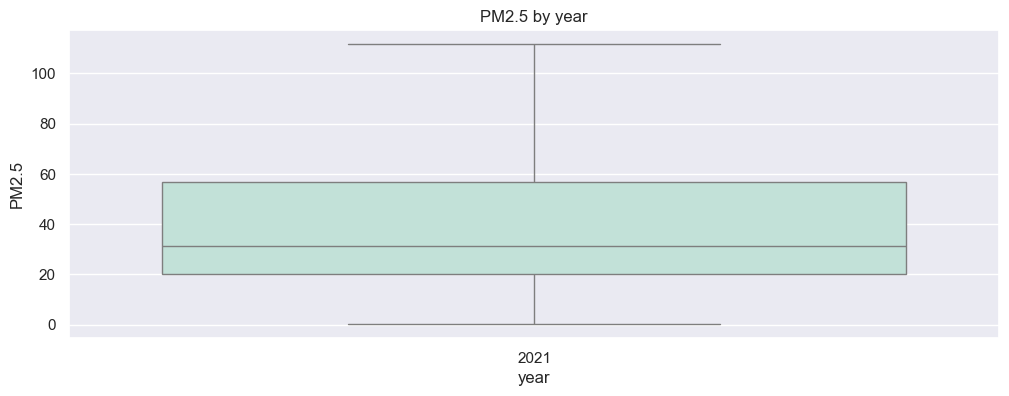

state  PM2.5  PM10   SO2   NO2     CO    O3  TEMP  \
datetime                                                                        
2013-03-01 00:00:00  Aotizhongxin    4.0   4.0   4.0   7.0  300.0  77.0  -0.7   
2013-03-01 01:00:00  Aotizhongxin    8.0   8.0   4.0   7.0  300.0  77.0  -1.1   
2013-03-01 02:00:00  Aotizhongxin    7.0   7.0   5.0  10.0  300.0  73.0  -1.1   
2013-03-01 03:00:00  Aotizhongxin    6.0   6.0  11.0  11.0  300.0  72.0  -1.4   
2013-03-01 04:00:00  Aotizhongxin    3.0   3.0  12.0  12.0  300.0  72.0  -2.0   

                       PRES  DEWP  RAIN  WSPM  hour  dayofmonth  dayofweek  \
datetime                                                                     
2013-03-01 00:00:00  1023.0 -18.8   0.0   4.4     0           1          4   
2013-03-01 01:00:00  1023.2 -18.2   0.0   4.7     1           1          4   
2013-03-01 02:00:00  1023.5 -18.2   0.0   5.6     2           1          4   
2013-03-01 03:00:00  1024.5 -19.4   0.0   3.1     3           1          4   
2013-03-01 04:00:00  1025.2 -19.5   0.0   2.0     4           1          4   

                     dayofyear  weekofyear  month  quarter  year  
datetime                                                          
2013-03-01 00:00:00         60           9      3        1  2013  
2013-03-01 01:00:00         60           9      3        1  2013  
2013-03-01 02:00:00         60           9      3        1  2013  
2013-03-01 03:00:00         60           9      3        1  2013  
2013-03-01 04:00:00         60           9      3        1  2013

In [81]:
plot_by_datetime('PM2.5', ['dayofmonth', 'dayofweek', 'weekofyear', 'month', 'quarter', 'year'])
df_china.head()

# Omogeneizzazione ed Unione dei DataFrame `df_india` e `df_china`

In questa sezione andremo a uniformare ed unire la struttura dei due DataFrame, contenenti dati sulla qualità dell'aria dell'India e della Cina, in un unico DataFrame per l'allenamento dei modelli di Regressione.


## Rinomina delle colonne in `df_india` per uniformarle a quelle di `df_china`

In questa cella rinominiamo alcune colonne di `df_india` in modo che abbiano gli stessi nomi utilizzati in `df_china`.
Ad esempio:
- `"PM2.5 (ug/m3)"` diventerà `"PM2.5"`
- `"CO (mg/m3)"` diventerà `"CO"`
- `"Ozone (ug/m3)"` diventerà `"O3"`


In [82]:
rename_map_df = {
    'PM2.5 (ug/m3)': 'PM2.5',
    'CO (mg/m3)': 'CO',
    'Ozone (ug/m3)': 'O3',
    'NOx (ug/m3)': 'NOx'
}

df_india.rename(columns=rename_map_df, inplace=True)

## Estrazione delle colonne comuni tra `df_india` e `df_china`

Una volta uniformati i nomi delle colonne, cerchiamo l'intersezione tra le colonne dei due DataFrame, cioè quelle che sono presenti in entrambi.
Questo ci permetterà di creare due DataFrame omogenei e pronti per essere concatenati.


In [83]:
common_columns = list(set(df_india.columns) & set(df_china.columns))

## Creazione dei DataFrame `df_india_aligned` e `df_china_aligned`

In questa fase creiamo due nuovi DataFrame (`df_aligned` e `df_china_aligned`) che contengono solo le colonne comuni.
In questo modo abbiamo una base uniforme su cui allenare i modelli in seguito.

In [84]:
df_aligned = df_india[common_columns].copy()
df_china_aligned = df_china[common_columns].copy()

print("Colonne comuni (omogeneizzate):")
print(df_aligned.columns)

Colonne comuni (omogeneizzate):
Index(['CO', 'dayofmonth', 'quarter', 'weekofyear', 'month', 'dayofweek',
       'PM2.5', 'state', 'O3', 'year', 'hour', 'dayofyear'],
      dtype='object')


## Concatenazione dei DataFrame omogeneizzati

Dopo aver uniformato le colonne, possiamo unire i due DataFrame in un unico dataset più grande. Questo ci permette di avere tutti i dati in un'unica struttura per analisi successive. Impostiamo il parametro `ignore_index=True` per riordinare gli indici nel DataFrame concatenato.

In [85]:
df = pd.concat([df_aligned, df_china_aligned], ignore_index=True)

## Verifica del risultato

Stampiamo le dimensioni e alcune righe del nuovo DataFrame concatenato `df` per assicurarci che l’unione sia avvenuta correttamente.\


In [86]:
print("Numero di righe:", df.shape[0])
print("Numero di colonne:", df.shape[1])

df.sample(5)

Numero di righe: 2123451
Numero di colonne: 12


CO  dayofmonth  quarter  weekofyear  month  dayofweek  \
1962502  800.000          29        3          31      7          1   
1023649    0.260          17        3          37      9          5   
685284     0.775           6        3          36      9          4   
735995     0.737          22        3          30      7          0   
1421440    0.210          28        2          26      6          5   

              PM2.5         state       O3  year  hour  dayofyear  
1962502   87.000000  Nongzhanguan  216.000  2014    17        210  
1023649   21.655000     Meghalaya    2.520  2022    18        260  
685284   113.940000     Karnataka   19.805  2013    12        249  
735995    17.696667     Karnataka   30.948  2019    12        203  
1421440   28.290625     Telangana   52.710  2014     3        179

## Riduzione Sampling

Riduciamo il timeframe compreso all'interno del Dataframe al periodo temporale in comune per entrambi i dataset.


In [ ]:
df = df[(df['year'] >= 2018) & (df['year'] <= 2022)]
df = df.reset_index(drop=True)
df.head()

CO  dayofmonth  quarter  weekofyear  month  dayofweek  PM2.5  \
0  0.48           1        3          26      7          4  10.67   
1  0.49           1        3          26      7          4   2.00   
2  0.49           1        3          26      7          4   2.00   
3  0.49           1        3          26      7          4   2.00   
4  0.47           1        3          26      7          4  20.50   

            state    O3  year  hour  dayofyear  
0  Andhra Pradesh  14.5  2016    10        183  
1  Andhra Pradesh  15.0  2016    11        183  
2  Andhra Pradesh  15.0  2016    12        183  
3  Andhra Pradesh  15.0  2016    13        183  
4  Andhra Pradesh  10.5  2016    14        183

In [88]:
# 1. Drop the 'hour' column
df = df.drop(columns=['hour'])

# 2. Group by date and state, and average the pollution values
df_daily = (
    df.groupby(['year', 'month', 'dayofmonth', 'state'], as_index=False)
      .agg({
          'PM2.5': 'mean',
          'CO': 'mean',
          'O3': 'mean',
          'dayofweek': 'first',
          'quarter': 'first',
          'weekofyear': 'first',
          'dayofyear': 'first'
      })
)

df_daily.head()

year  month  dayofmonth         state       PM2.5          CO         O3  \
0  2015      1           1  Aotizhongxin   38.166667  941.666667  24.166667   
1  2015      1           1         Bihar   92.000000    0.740000  43.160000   
2  2015      1           1     Changping   28.375000  800.000000  37.083333   
3  2015      1           1         Delhi  208.485000    7.348611  45.935000   
4  2015      1           1      Dingling   32.958333  650.000000  49.833333   

   dayofweek  quarter  weekofyear  dayofyear  
0          3        1           1          1  
1          3        1           1          1  
2          3        1           1          1  
3          3        1           1          1  
4          3        1           1          1

## Integrazione Augmented Dataset

Inseriamo all'interno del dataframe omogeneizzato i valori generati dai vari llm sostituendo l'anno 2021


In [89]:
# Split the original df
before_2021_unf = df_daily[df_daily['year'] < 2021]
after_2021 = df_daily[df_daily['year'] > 2021]

before_2021 = before_2021_unf[before_2021_unf['state'].isin(valid_states)].copy()

# Concatenate in order: before -> new 2021 -> after
df = pd.concat([before_2021, df_augmented, after_2021], ignore_index=True)

df.head()


year  month  dayofmonth        state       PM2.5        CO          O3  \
0  2015      1           1        Bihar   92.000000  0.740000   43.160000   
1  2015      1           1        Delhi  208.485000  7.348611   45.935000   
2  2015      1           1      Gujarat   27.211081  5.068095  104.372381   
3  2015      1           1    Karnataka  113.940000  0.417569   26.905625   
4  2015      1           1  Maharashtra   79.599167  0.530417    0.040000   

   dayofweek  quarter  weekofyear  dayofyear  
0          3        1           1          1  
1          3        1           1          1  
2          3        1           1          1  
3          3        1           1          1  
4          3        1           1          1

# Aggiunta Lag Features

Le cosiddette “lag features” consentono di includere nei modelli i valori storici di una variabile, risultando spesso determinanti nelle previsioni grazie al loro elevato potere predittivo. Possiamo inoltre generare lag anche per altre variabili significative, ampliando il contesto informativo del dataset e potenzialmente migliorando la precisione delle stime.

Analizzando i boxplot, abbiamo osservato che alcune feature evidenziano trend stagionali o andamenti rilevanti nel tempo. Sulla base di queste evidenze, creeremo lag features mirate per sfruttare al meglio tali pattern.

In [ ]:
def create_lag_features(df):
    df = df.copy()
    df = df.sort_values(by=['state', 'date'])
    df['date'] = pd.to_datetime(dict(year=df['year'], month=df['month'], day=df['dayofmonth']))
    df[['pm_lag_1Y','co_lag_1Y','o3_lag_1Y']] = df.groupby('state')[['PM2.5','CO','O3']].shift(365)  # 1 year lag
    df[['pm_lag_2Y','co_lag_2Y','o3_lag_2Y']] = df.groupby('state')[['PM2.5','CO','O3']].shift(730)   # 2 year lag
    df[['pm_lag_1M','co_lag_1M','o3_lag_1M']] = df.groupby('state')[['PM2.5','CO','O3']].shift(30)   # 1 month lag
    df[['pm_lag_1W','co_lag_1W','o3_lag_1W']] = df.groupby('state')[['PM2.5','CO','O3']].shift(7)   # 1 week lag
    df = df.sort_values(by=['date'])
    return df

In [95]:
lag_features = ['pm_lag_1Y', 'pm_lag_2Y', 'pm_lag_1M', 'pm_lag_1W','co_lag_1Y', 'co_lag_2Y', 'co_lag_1M', 'co_lag_1W','o3_lag_1Y', 'o3_lag_2Y', 'o3_lag_1M', 'o3_lag_1W']
df = create_lag_features(df)
df_daily = create_lag_features(df_daily)
df_daily.head()

year  month  dayofmonth          state       PM2.5           CO  \
19  2015      1           1  Wanshouxigong   35.208333  1137.500000   
9   2015      1           1        Huairou   22.791667   870.833333   
0   2015      1           1   Aotizhongxin   38.166667   941.666667   
17  2015      1           1  Uttar Pradesh  322.298261     6.678757   
5   2015      1           1         Dongsi   28.333333  1000.000000   

           O3  dayofweek  quarter  weekofyear  dayofyear       date  \
19  34.291667          3        1           1          1 2015-01-01   
9   30.083333          3        1           1          1 2015-01-01   
0   24.166667          3        1           1          1 2015-01-01   
17  33.138014          3        1           1          1 2015-01-01   
5   33.750000          3        1           1          1 2015-01-01   

    pm_lag_1Y  co_lag_1Y  o3_lag_1Y  pm_lag_2Y  co_lag_2Y  o3_lag_2Y  \
19        NaN        NaN        NaN        NaN        NaN        NaN   
9         NaN        NaN        NaN        NaN        NaN        NaN   
0         NaN        NaN        NaN        NaN        NaN        NaN   
17        NaN        NaN        NaN        NaN        NaN        NaN   
5         NaN        NaN        NaN        NaN        NaN        NaN   

    pm_lag_1M  co_lag_1M  o3_lag_1M  pm_lag_1W  co_lag_1W  o3_lag_1W  
19        NaN        NaN        NaN        NaN        NaN        NaN  
9         NaN        NaN        NaN        NaN        NaN        NaN  
0         NaN        NaN        NaN        NaN        NaN        NaN  
17        NaN        NaN        NaN        NaN        NaN        NaN  
5         NaN        NaN        NaN        NaN        NaN        NaN

In [96]:
df.info()
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51912 entries, 0 to 51911
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   year        51912 non-null  int64         
 1   month       51912 non-null  int64         
 2   dayofmonth  51912 non-null  int64         
 3   state       51912 non-null  object        
 4   PM2.5       51912 non-null  float64       
 5   CO          51912 non-null  float64       
 6   O3          51912 non-null  float64       
 7   dayofweek   51912 non-null  int64         
 8   quarter     51912 non-null  int64         
 9   weekofyear  51912 non-null  int64         
 10  dayofyear   51912 non-null  int64         
 11  date        51912 non-null  datetime64[ns]
 12  pm_lag_1Y   40979 non-null  float64       
 13  co_lag_1Y   40979 non-null  float64       
 14  o3_lag_1Y   40979 non-null  float64       
 15  pm_lag_2Y   33005 non-null  float64       
 16  co_lag_2Y   33005 non-null 

A seguito della creazione delle lag features, riscontriamo che i primi record del dataset presentano valori mancanti: ciò è inevitabile, dato che non esistono dati storici precedenti per calcolare i ritardi temporali. È quindi fondamentale gestire con cura questi missing values, poiché molti algoritmi predittivi non possono elaborare dati incompleti. Per affrontare questo problema, implementeremo una funzione dedicata al trattamento dei NaN generati dai lag, tenendo presente che questa operazione, pur necessaria per confrontare le performance dei modelli, potrebbe introdurre bias o comportare la perdita di informazioni nei periodi iniziali di raccolta.

# Creazione Dataset per l'allenamento

Esportiamo i due dataset, originale e augmented, per proseguire con l'allenamento nel file successivo


In [95]:
df.to_csv('augmented_dataset.csv', index=False)
df_daily.to_csv('original_dataset.csv', index=False)

In [ ]:
if running_in_colab:
  google.colab.files.download('./original_dataset.csv')
  google.colab.files.download('./augmented_dataset.csv')